In [1]:
import os
import csv  
import pdb
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import kstest

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import patches
from matplotlib.patches import Rectangle
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

import rvsearch

import occur
from occur import Completeness, Hierarchy, PowerLaw

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
sysprops = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
#objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
# Now including GL 876 small inner planet in the sample, in this repo's tables.
objects = pd.read_csv('legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

## How many stars that host small planets have linear or parabolic trends?

In [6]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [7]:
[name for name in trend_names if name in small_names]

['156668', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be directly modeling activity.

## Inner super-Earths and outer gas giants

In [8]:
# HD 143761 has an inner giant and an outer small planet. Weirdo.
# Drop 55 Cnc e from the super list for now. Too close-in to be detected.
#supers = planets.query('mass < 0.1 and axis > 0.025 and hostname != "143761"').reset_index(drop=True)
supers = planets.query('mass < 0.1 and axis < 1 and hostname != "143761"').reset_index(drop=True)
giants = planets.query('mass >= 0.1')
giantnames = np.unique(giants.hostname)
supernames = np.unique(supers.hostname)
print(len(supers), len(np.unique(supers.hostname)))

42 29


In [9]:
superspec = specmatch.query('name in @supernames')
giantspec = specmatch.query('name in @giantnames')

In [10]:
outers = planets.query('mass >= 0.1 and hostname in @supernames and hostname != "143761"').reset_index(drop=True)
outernames = np.unique(outers.hostname) # and axis > 0.3

In [11]:
outerspec = specmatch.query('name in @outernames')

In [12]:
pairs = planets.query('hostname in @outernames and hostname != "143761"').reset_index(drop=True)
solos = planets.query('mass < 0.1 and not (hostname in @outernames) and hostname != "143761"')
pairnames = np.unique(pairs.hostname)
solonames = np.unique(solos.hostname)

In [13]:
giants = planets.query('mass >= 0.1')
giantnames = np.unique(giants.hostname)

## Preliminary statistics.

In [14]:
all_outers  = planets.query('mass >= 0.1 and axis > 0.23 and hostname != "143761"')
allouternames = list(np.unique(all_outers.hostname))
inners = planets.query('mass < 0.1 and hostname in @allouternames and hostname != "143761"').reset_index(drop=True)

In [15]:
print(len(supers), 'small planets,', len(outers), 'outer companions,', len(outers)/len(supers))

42 small planets, 13 outer companions, 0.30952380952380953


In [16]:
print(len(np.unique(supers.hostname)), 'small planet systems,', len(np.unique(outers.hostname)), 
      'inner and outer systems,', len(np.unique(outers.hostname))/len(np.unique(supers.hostname)))

29 small planet systems, 9 inner and outer systems, 0.3103448275862069


In [17]:
print(len(all_outers), 'cold giants,', len(inners), 'inner companions,', len(inners)/len(all_outers))

111 cold giants, 13 inner companions, 0.11711711711711711


In [18]:
print(len(np.unique(all_outers.hostname)), 'cold giant systems,', len(np.unique(inners.hostname)), 
      'inner and outer systems,', len(np.unique(inners.hostname))/len(np.unique(all_outers.hostname)))

81 cold giant systems, 8 inner and outer systems, 0.09876543209876543


## Compare metallicities of all small-planet hosts and inner-outer pair hosts.

In [15]:
stellar_giants = specmatch.query('name in @giantnames')
stellar_supers = specmatch.query('name in @supernames')
stellar_solos  = specmatch.query('name in @solonames')
stellar_pairs  = specmatch.query('name in @pairnames')

In [20]:
print(len(stellar_giants), len(stellar_supers), len(stellar_solos), len(stellar_pairs))

96 29 20 9


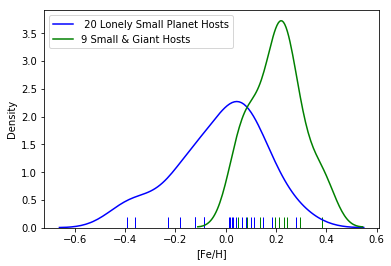

In [21]:
fig, ax = plt.subplots()

sns.distplot(stellar_solos.fe_c, rug=True, hist=False, kde=True, ax=ax, color='blue', \
             label=' {} Lonely Small Planet Hosts'.format(len(stellar_solos)))
sns.distplot(stellar_pairs.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Small & Giant Hosts'.format(len(stellar_pairs)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/pair_solo_fe_histogram.pdf')

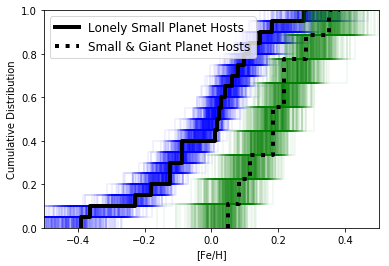

In [22]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=20*len(stellar_solos))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(stellar_solos.fe_c, normed=True, bins=20*len(stellar_solos))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Lonely Small Planet Hosts')


for i in np.arange(500):
    metals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True)#bins=19
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(stellar_pairs.fe_c, normed=True)#bins=19
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Small & Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12, loc=2)

fig.savefig('plots/metallicity_cumulative_lonely_pair.pdf', bbox_inches='tight')

In [23]:
darlings = []
dprobs = []
for i in np.arange(10**5):
    solometals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    pairmetals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    anderson = scipy.stats.anderson_ksamp([solometals, pairmetals])
    darlings.append(anderson[0])
    dprobs.append(anderson[2])

KeyboardInterrupt: 

In [16]:
kolmogorovs = []
probs = []
for i in np.arange(5*10**5):
    solometals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    pairmetals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, pairmetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [ ]:
print(scipy.stats.percentileofscore(probs, 0.01, kind='rank'),
      scipy.stats.percentileofscore(probs, 0.05, kind='rank'))

In [ ]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.hist(np.log10(dprobs), bins=30, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-2.76, -1])
ax.set_ylim([0, 1])
ax.legend(fontsize=12, loc=1)
fig.savefig('plots/ad_pvalue_lonely_pair.pdf', bbox_inches='tight')

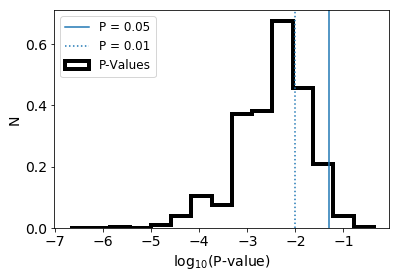

In [22]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.hist(np.log10(probs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
#logbins = np.logspace(np.log10(np.amin(probs)), np.log10(np.amax(probs)), 15)
#ax.hist(probs, bins=logbins, histtype='step', density=True, 
#        lw=4, color='black', label='P-Values')
#ax.set_xscale('log')
#ax.axvline(0.05, label='P = 0.05')
#ax.axvline(0.01, ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(fontsize=12)
#fig.savefig('plots/ks_pvalue_lonely_pair.pdf', bbox_inches='tight')

In [ ]:
kolmogorov = scipy.stats.ks_2samp(stellar_solos.fe_c, stellar_pairs.fe_c)
print(kolmogorov[1])

In [ ]:
fig, ax = plt.subplots()

sns.distplot(stellar_giants.fe_c, rug=False, hist=False, kde=True, ax=ax, color='red', \
             label=' {} Giant Planet Hosts'.format(len(stellar_giants)))
sns.distplot(stellar_pairs.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Small & Giant Hosts'.format(len(stellar_pairs)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/pair_solo_fe_histogram.pdf')

In [ ]:
# np.insert(simple_counts, 0, simple_counts[0])
# np.insert(simple_counts, 0, 0)

fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_giants))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(stellar_giants.fe_c, normed=True, bins=2*len(stellar_giants))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Giant Planet Hosts')


for i in np.arange(500):
    metals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True)#bins=19
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(stellar_pairs.fe_c, normed=True)#bins=19
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Small & Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

fig.savefig('plots/metallicity_cumulative_giant_pair.pdf', bbox_inches='tight')

In [ ]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    giantmetals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    pairmetals  = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    kolmogorov  = scipy.stats.ks_2samp(giantmetals, pairmetals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=23, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-2.1, 0])
ax.legend(loc=2)
fig.savefig('plots/pvalue_giant_pair.pdf', bbox_inches='tight')

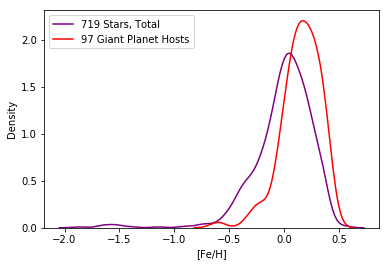

In [50]:
fig, ax = plt.subplots()

sns.distplot(specmatch.fe_c, rug=False, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Stars, Total'.format(len(specmatch)))
sns.distplot(stellar_giants.fe_c, rug=False, hist=False, kde=True, ax=ax, color='red', \
             label='{} Giant Planet Hosts'.format(len(stellar_giants)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/all_giant_fe_histogram.pdf')

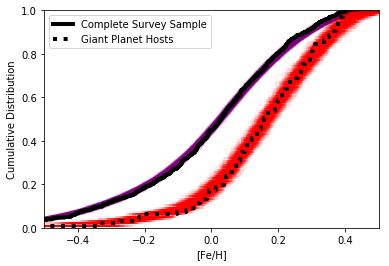

In [38]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(specmatch))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(specmatch.fe_c, normed=True, bins=2*len(specmatch))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Complete Survey Sample')


for i in np.arange(500):
    metals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_giants))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    
    
hist, edges = np.histogram(stellar_giants.fe_c, normed=True, bins=2*len(stellar_giants))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

fig.savefig('plots/metallicity_cumulative_all_giants.pdf', bbox_inches='tight')

In [39]:
kolmogorovs = []
probs = []
for i in np.arange(10**4):
    allmetals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    giantmetals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(allmetals, giantmetals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

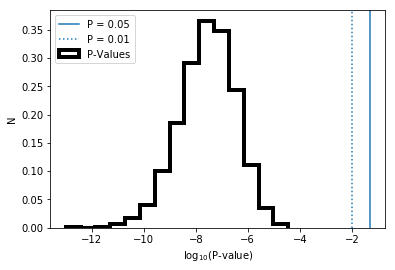

In [40]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend()
fig.savefig('plots/pvalue_all_giants.pdf', bbox_inches='tight')

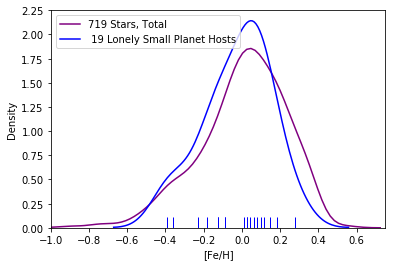

In [51]:
fig, ax = plt.subplots()

sns.distplot(specmatch.fe_c, rug=False, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Stars, Total'.format(len(specmatch)))
sns.distplot(stellar_solos.fe_c, rug=True, hist=False, kde=True, ax=ax, color='blue', \
             label=' {} Lonely Small Planet Hosts'.format(len(stellar_solos)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.set_xlim([-1, 0.75])
ax.legend(loc=2)
fig.savefig('plots/all_solosmall_fe_histogram.pdf')

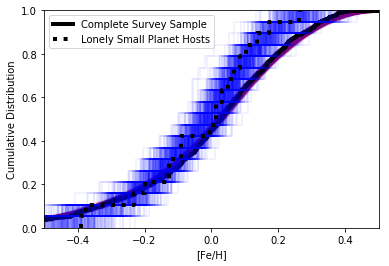

In [117]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(specmatch))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(specmatch.fe_c, normed=True, bins=2*len(specmatch))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Complete Survey Sample')


for i in np.arange(500):
    metals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_solos))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    
    
hist, edges = np.histogram(stellar_solos.fe_c, normed=True, bins=2*len(stellar_solos))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Lonely Small Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

In [42]:
kolmogorovs = []
probs = []
for i in np.arange(10**4):
    allmetals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    solometals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(allmetals, solometals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

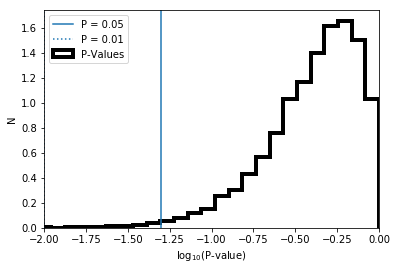

In [52]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=25, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(loc=2)
ax.set_xlim([-2, 0])
fig.savefig('plots/pvalue_all_lonely.pdf', bbox_inches='tight')

## Compare mass & eccentricity distributions of outer giant companions to all giants.

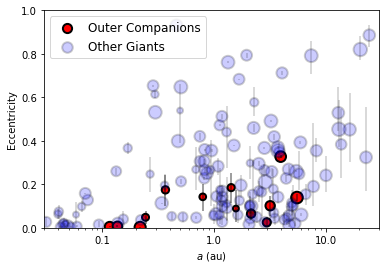

In [17]:
giants = planets.query('mass > 0.1')

fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

outies = pairs.query('mass >= 0.1')
outynames = list(np.unique(outies.hostname))
nouties = planets.query('mass >= 0.1 and hostname not in @outynames')

ax.scatter(outies.axis_med, outies.e_med, 
           s=list(30*np.log(30*outies.mass)), 
           c='red', edgecolors='black', 
           alpha=1, linewidth=2, 
           label='Outer Companions')
ax.vlines(outies.axis_med, outies.e_minus, outies.e_plus, 
          alpha=0.5, color='black', label='_nolegend_')

ax.scatter(nouties.axis_med, nouties.e_med, 
           s=list(30*np.log(30*nouties.mass)), 
           c='blue', edgecolors='black', 
           alpha=0.2, linewidth=2,
           label='Other Giants')
ax.vlines(nouties.axis_med, nouties.e_minus, nouties.e_plus, 
          alpha=0.2, color='black', label='_nolegend_')

ax.legend(fontsize=12)
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
fig.savefig('plots/axis_eccentricity_outies_ci.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/axis_eccentricity_outies_ci.pdf', bbox_inches='tight')

In [18]:
giants = planets.query('mass >= 0.1')
print(np.median(outies.e_med), np.median(nouties.e_med))
print(np.median(outies.e_med), np.median(giants.e_med))
print(np.std(outies.e_med), np.std(giants.e_med))

0.08857326043 0.1901637344
0.08857326043 0.16963969909999999
0.08977116518114886 0.21477160194044023


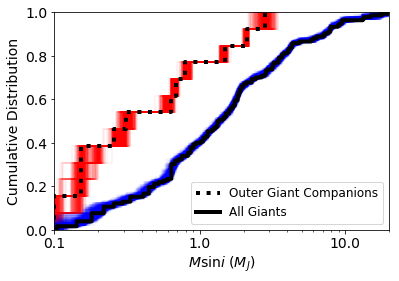

In [56]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10, 100))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

for i in np.arange(500):
    masses = np.random.normal(outies.mass_med, 0.5*(outies.mass_plus - outies.mass_minus))
    hist, edges = np.histogram(masses, normed=True, bins=4*len(outies))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(outies.mass_med, normed=True, bins=4*len(outies))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Outer Giant Companions')

for i in np.arange(500):
    masses = np.random.normal(planets.query('mass_med>=0.1').mass_med, 
                              0.5*(planets.query('mass_med>=0.1').mass_plus - planets.query('mass_med>=0.1').mass_minus))
    hist, edges = np.histogram(masses, normed=True, bins=4*len(planets))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(planets.query('mass_med>=0.1').mass_med, normed=True, bins=4*len(planets))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='All Giants')

#ax.set_xscale('log')
ax.set_xlim([0.1, 20])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$M$sin$i$ ($M_J$)')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/cumulative_mass.pdf', bbox_inches='tight')

## Get diggity with some occurrence work.

In [19]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    dlna = (lna2 - lna1)/resa
    dlnM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*dlna, lna1 + (i+1)*dlna], 
                         [lnM1 + j*dlnM, lnM1 + (j+1)*dlnM]])
            
    return np.array(bins)

In [20]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [21]:
samples_all = pd.read_csv('../legacy_samples/samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]# or '_e' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

# Trim out planets that don't belong in each sample.
#columns_outers = [col for col in samples_all.columns if col[:-2] in list(supers.hostname)]
#columns_small = [col for col in samples_all.columns if col[:-2] in list(all_outers.hostname)]
columns_good = []
e_cols = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    #e_col = planet[:-2] + '_e' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        #columns_good.append(e_col)
        #e_cols.append(e_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [16]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins)
hierarchical_one.max_like()

KeyboardInterrupt: 

In [33]:
hierarchical_one.sample(parallel=True, gp=False)

  2%|▏         | 21/1000 [01:02<51:01,  3.13s/it]Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIII/occur.py", line 247, in lnpost
    return self.lnlike(theta)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIII/occur.py", line 239, in lnlike
    np.exp(lnm_av))*self.occurrence(
  File "/Users/lee/Academics/Astronomy/Planets/CLSIII/occur.py", line 104, in interpolate
    return self.interpolator(np.array([np.atleast_1d(x), np.atleast_1d(y)]).T)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py", line 2493, in __call__
    out_of_bounds)
  File "/Users/lee/anac

emcee: Exception while calling your likelihood function:
  params: [ 3.02655061  2.07054924  2.51040577  4.37673077  3.01329358 10.78790209
  9.92178791 11.84074754 11.177629    6.91226362  7.26093049]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

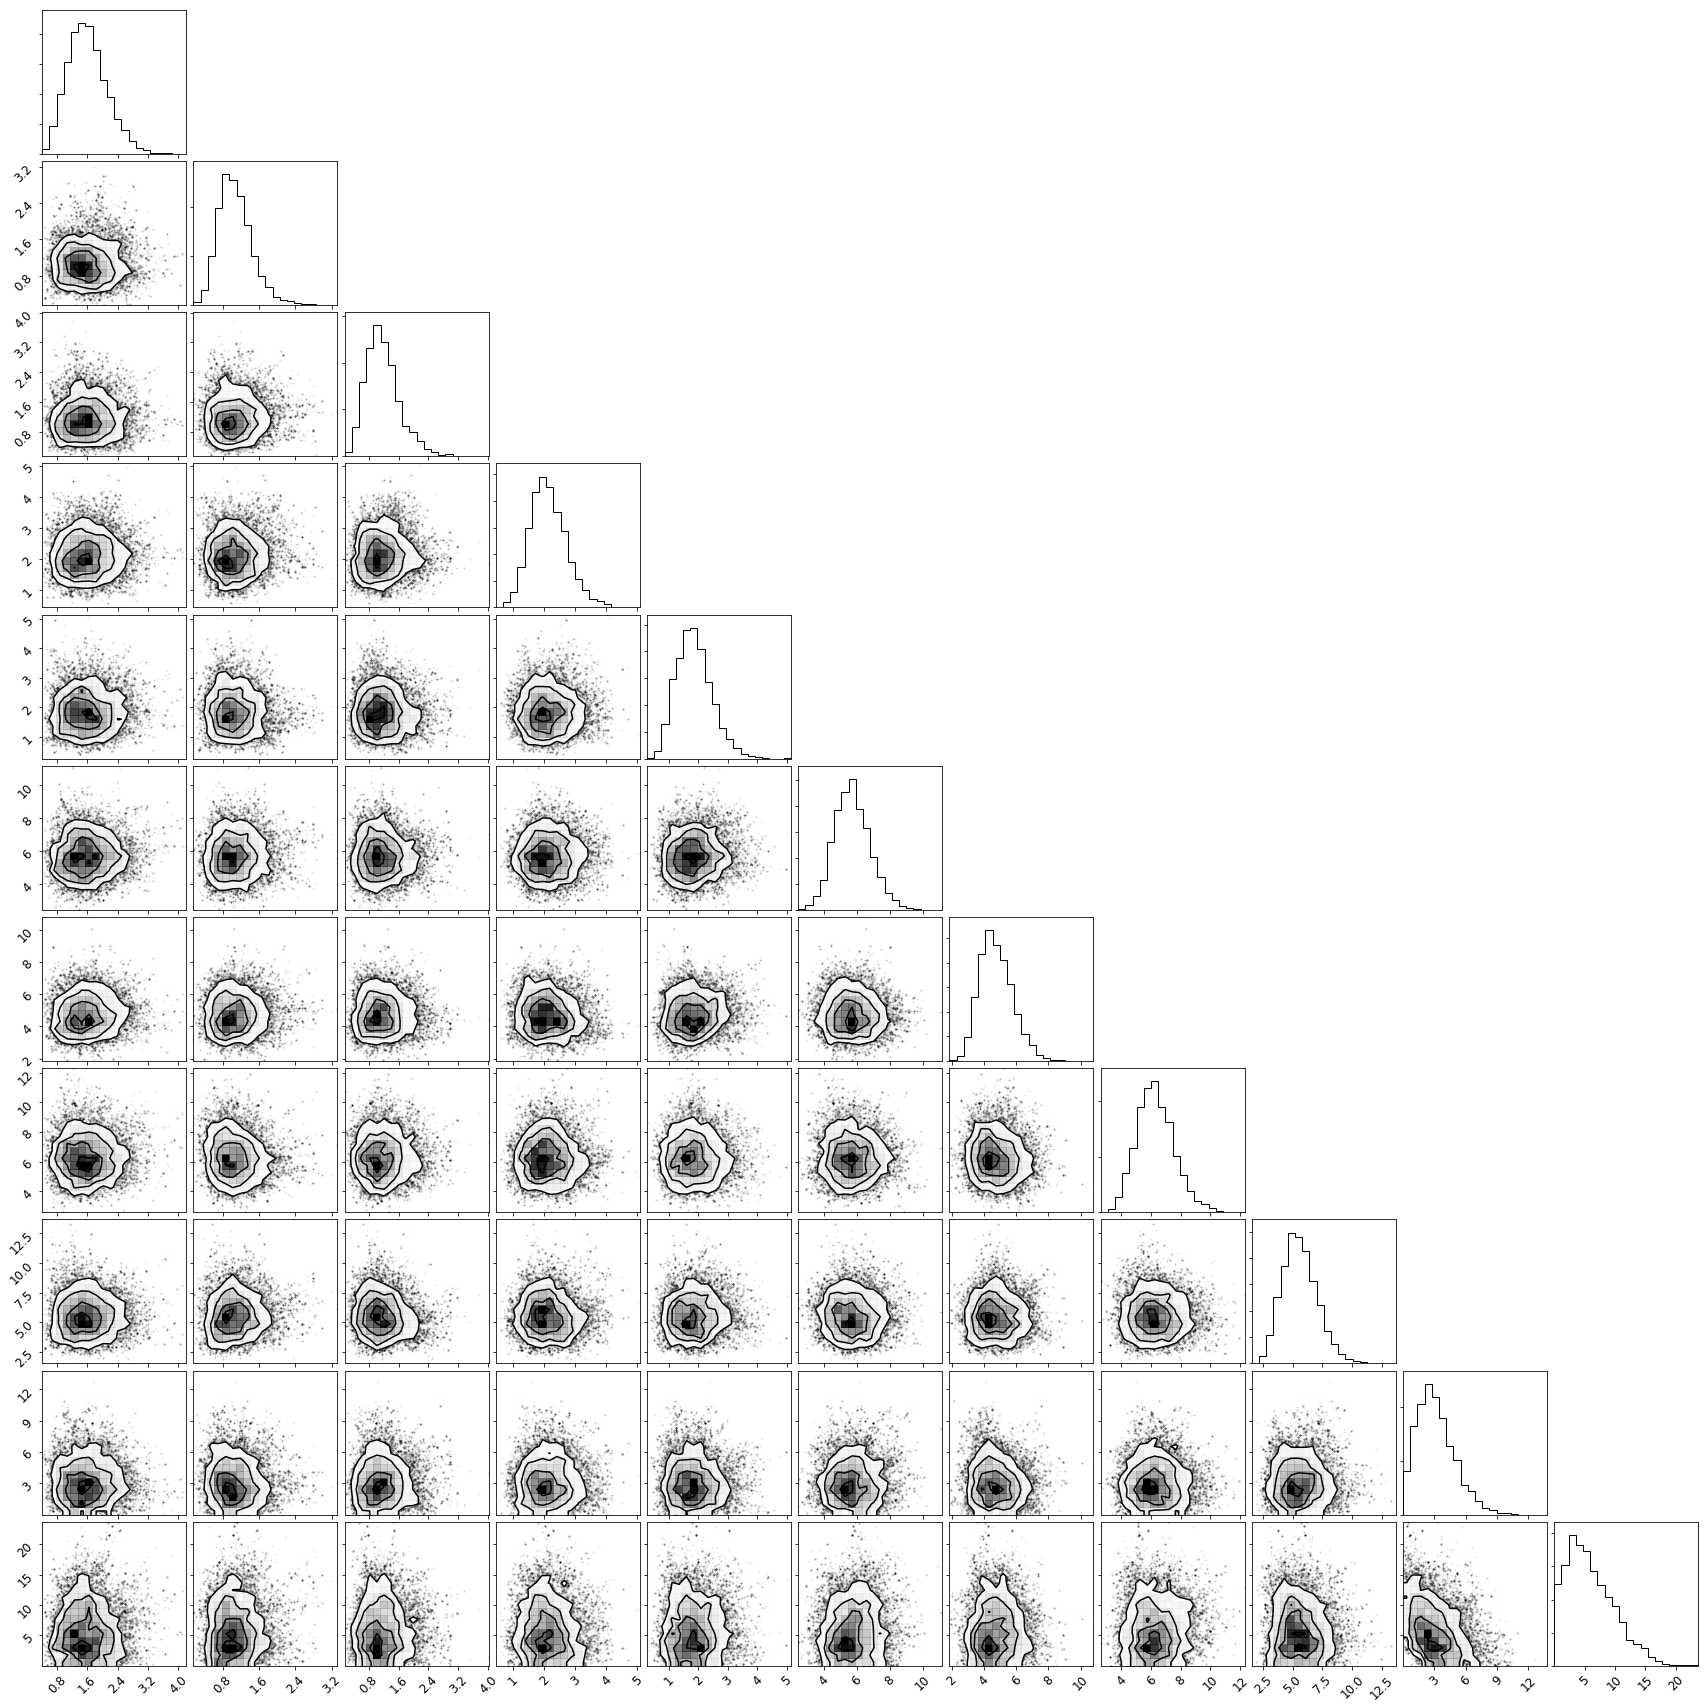

In [73]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('corner_11x1_1014.pdf')

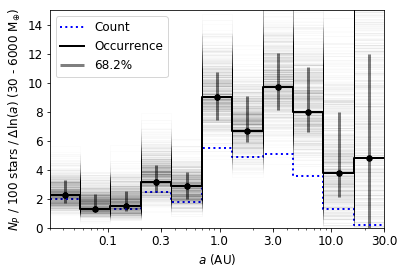

In [64]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')

for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
 
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_fancy_mode.pdf', bbox_inches='tight')

## Do outer companion work.

In [22]:
recoveries_small = pd.read_csv('../recovery_files/recoveries_small_earth.csv')
completey_small  = Completeness(recoveries_small)
completey_small.completeness_grid([0.01, 40], [2, 9000])

recoveries_outer = pd.read_csv('../recovery_files/recoveries_outer_earth.csv')
completey_outer  = Completeness(recoveries_outer)
completey_outer.completeness_grid([0.01, 40], [2, 9000])

recoveries_jupiter = pd.read_csv('../recovery_files/recoveries_jupiters_earth.csv')
completey_jupiter  = Completeness(recoveries_jupiter)
completey_jupiter.completeness_grid([0.01, 40], [2, 9000])

recoveries_pairs = pd.read_csv('../recovery_files/recoveries_small_and_outer_earth.csv')
completey_pairs  = Completeness(recoveries_pairs)
completey_pairs.completeness_grid([0.01, 40], [2, 9000])

recoveries_warm = pd.read_csv('../recovery_files/recoveries_warmgiants_earth.csv')
completey_warm  = Completeness(recoveries_warm)
completey_warm.completeness_grid([0.01, 40], [2, 9000])

recoveries_lukewarm = pd.read_csv('../recovery_files/recoveries_lukewarm_earth.csv')
completey_lukewarm  = Completeness(recoveries_lukewarm)
completey_lukewarm.completeness_grid([0.01, 40], [2, 9000])

recoveries_cold = pd.read_csv('../recovery_files/recoveries_cold_earth.csv')
completey_cold  = Completeness(recoveries_cold)
completey_cold.completeness_grid([0.01, 40], [2, 9000])

recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

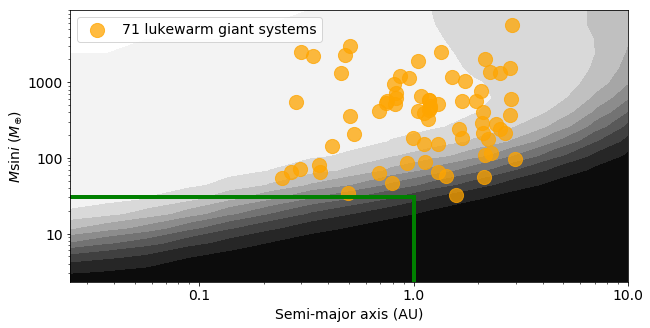

In [32]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_lukewarm.grid[0], completey_lukewarm.grid[1],
                 completey_lukewarm.grid[2], 10, cmap=plt.cm.gray)

ax.set_xlim([2.5*10**-2, 10])
ax.set_ylim([2.3, 9000])

lukewarmies = planets.query('mass>=0.1 and axis>=0.23 and axis<3')
ax.scatter(lukewarmies.axis, 317.8*lukewarmies.mass, c='orange', s=200, alpha=0.75, 
           label='{} lukewarm giant systems'.format(len(lukewarmies)))

xin = [0.02, 1]
yin = [2, 30]
ax.add_patch(Rectangle((xin[0], yin[0]), xin[1]-xin[0], yin[1]-yin[0], lw=4, color='green', fill=False))

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend()

fig.savefig('plots/completeness_lukewarm.pdf', bbox_inches='tight')

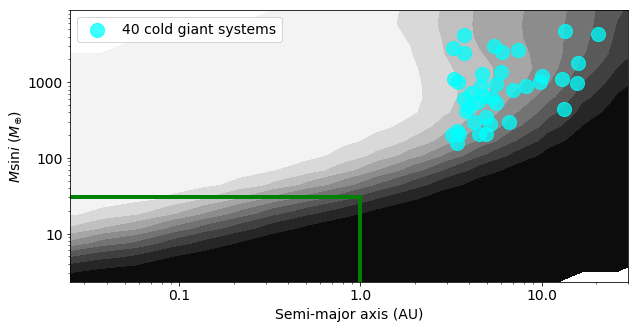

In [33]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_cold.grid[0], completey_cold.grid[1],
                 completey_cold.grid[2], 10, cmap=plt.cm.gray)

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

coldies = planets.query('mass>=0.1 and axis>=3')
ax.scatter(coldies.axis, 317.8*coldies.mass, c='cyan', s=200, alpha=0.75, 
           label='{} cold giant systems'.format(len(coldies)))

xin = [0.02, 1]
yin = [2, 30]
ax.add_patch(Rectangle((xin[0], yin[0]), xin[1]-xin[0], yin[1]-yin[0], lw=4, color='green', fill=False))

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend()

fig.savefig('plots/completeness_cold.pdf', bbox_inches='tight')

In [28]:
warmbins = np.array([[[np.log(0.023), np.log(0.5)], [np.log(2.), np.log(30)]]])
hierarchical_warm_empty = Hierarchy(samples_first_jupi, completey_warm, bins=warmbins, res=16)
hierarchical_warm_empty.max_like()

In [29]:
int(round(4.6))

5

In [30]:
hierarchical_warm_empty.sample()

100%|██████████| 1000/1000 [00:42<00:00, 23.74it/s]


In [32]:
warm_post = hierarchical_warm_empty.chains*hierarchical_warm_empty.bin_areas[0][0]*(1/len(warmnames))

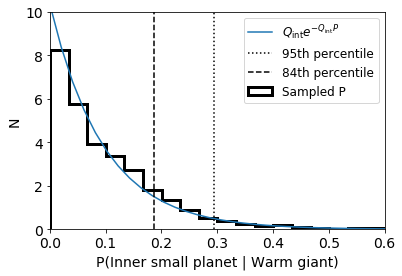

In [48]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.hist(warm_post, color='black', bins=20, histtype='step', lw=3, density=True, label=r'Sampled P')

#0.6
factor = 0.6*hierarchical_warm_empty.Qints[0]*hierarchical_warm_empty.bin_areas[0][0]
x = np.linspace(0, 1)
y = (factor)*np.exp(-x*factor)
ax.plot(x, y, label=r'$Q_{\mathrm{int}}e^{-Q_{\mathrm{int}}P}$')

ax.axvline(np.percentile(warm_post, 95), ls=':', color='black', label='95th percentile')
ax.axvline(np.percentile(warm_post, 84.1), ls='--', color='black', label='84th percentile')
#ax.axvline(np.percentile(warm_post, 50), ls='-', color='black', label='50th percentile')

ax.set_xlim([0, 0.6])
ax.set_ylim([0, 10])
ax.set_xlabel('P(Inner small planet | Warm giant)')
ax.set_ylabel('N')
ax.legend(fontsize=12)
fig.savefig('plots/fraction_inner_given_warm.pdf', bbox_inches='tight')

### Computer P(WJ) and P(WJ|SE).

In [29]:
warmbins = np.array([[[np.log(0.2), np.log(2)], [np.log(30), np.log(3000)]]])
hierarchical_warm = Hierarchy(samples_all, completey_all, bins=warmbins, res=16)
hierarchical_warm.max_like()

In [30]:
hierarchical_warm.sample()

100%|██████████| 1000/1000 [02:50<00:00,  5.88it/s]


In [31]:
warm_post = hierarchical_warm.chains*hierarchical_warm.bin_areas[0][0]*(100/719)

In [33]:
print(np.median(warm_post), '+/-', np.std(warm_post))

11.414888697911362 +/- 1.591909609156317


In [34]:
print(np.median(warm_post), np.percentile(warm_post, 15.9), np.percentile(warm_post, 84.1))

11.414888697911362 9.870581216990026 12.936898326964359


### Plot whole sample.

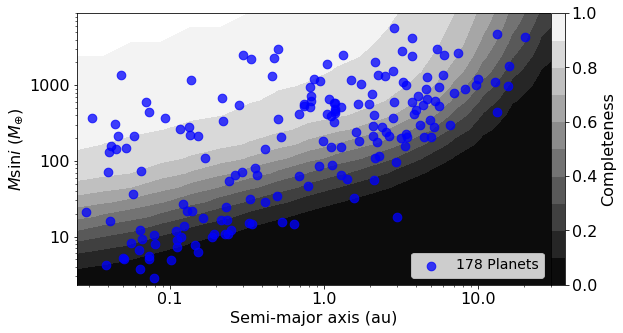

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

matplotlib.rcParams.update({'font.size': 16})
ax.scatter(planets.axis, 317.8*planets.mass, c='b', s=75, alpha=0.75, 
           label='{} Planets'.format(len(planets)))
#ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
#           label='{} Known'.format(len(planets_old)))
#ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
#           label='{} New'.format(len(planets_new)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4, fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_contours.pdf', bbox_inches='tight')

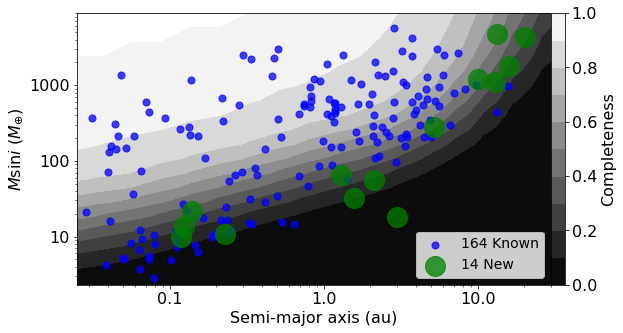

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

matplotlib.rcParams.update({'font.size': 16})
#ax.scatter(planets.axis, 317.8*planets.mass, c='b', s=75, alpha=0.75, 
#           label='{} Planets'.format(len(planets)))
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4, fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/m_a_scatter_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/m_a_scatter_contours.pdf', bbox_inches='tight')

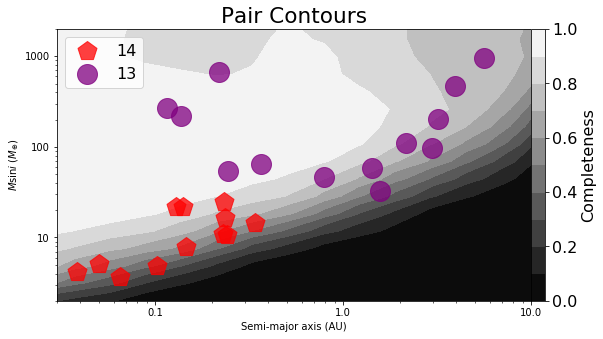

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_pairs.grid[0], completey_pairs.grid[1],
                 completey_pairs.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers#.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Pair Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{}'.format(len(pair_inner)), marker='p') #  inner small companions
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{}'.format(len(pair_outer))) # outer giant companions
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

#fig.savefig('plots/pair_contours.png', dpi=500, bbox_inches='tight')
#fig.savefig('plots/pair_contours.pdf', bbox_inches='tight')

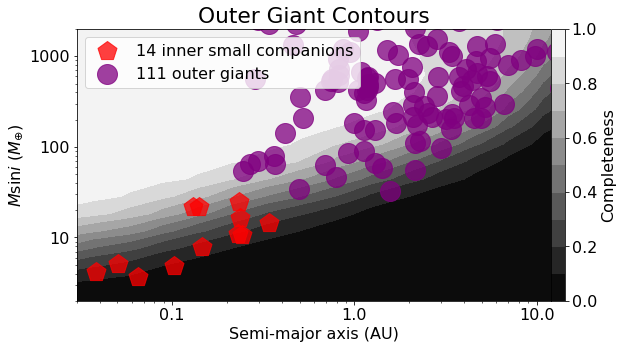

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_outer.grid[0], completey_outer.grid[1],
                 completey_outer.grid[2], 10, cmap=plt.cm.gray)

pair_outer = all_outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Outer Giant Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giants'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_all_outers.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_all_outers.pdf', bbox_inches='tight')

NameError: name 'completey_small' is not defined

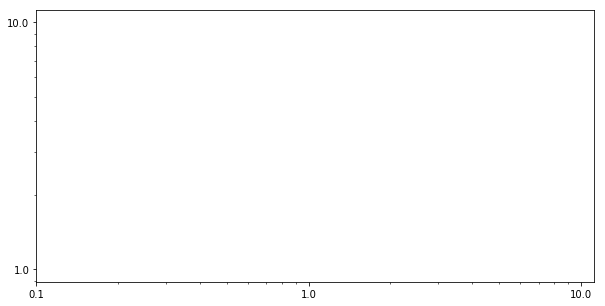

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_small.grid[0], completey_small.grid[1],
                 completey_small.grid[2], 10, cmap=plt.cm.gray)

pair_outer = planets.query('hostname in @supernames and mass >= 0.1') #outers#.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')
solos_in   = solos.query('axis < 1')

matplotlib.rcParams.update({'font.size': 16})
#ax.set_title('Small Planet Contours')
ax.scatter(solos_in.axis, 317.8*solos_in.mass, c='g', s=400, alpha=0.75, 
           label='{} solo small planets'.format(len(solos_in)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4, fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

#fig.savefig('plots/small_planet_contours.png', dpi=500, bbox_inches='tight')
#fig.savefig('plots/small_planet_contours.pdf', bbox_inches='tight')

## Make sampling dataframes for planet subsets.

In [23]:
samples_all = pd.read_csv('../legacy_samples/samples_all_joker.csv').sample(500).reset_index(drop=True)
samples_med = samples_all.median()

columns = [col for col in samples_all.columns if ('_M' in col or '_a' in col)]
samples_all = samples_all[columns]
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_outers     = []
columns_outers_all = []
columns_small      = []

for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.2) and (samples_med[M_col] > 0.08) and planet[:-2] in list(supers.hostname):
        columns_outers.append(a_col)
        columns_outers.append(M_col)
    if (samples_med[a_col] > 0.2) and (samples_med[M_col] > 0.08):
        columns_outers_all.append(a_col)
        columns_outers_all.append(M_col)
    if samples_med[M_col] < 0.11 and planet[:-2] in list(all_outers.hostname):
        columns_small.append(a_col)
        columns_small.append(M_col)

samples_small = samples_all[columns_small]
for col in columns_small:
    if '_M' in col:
        samples_small[col] *= 317.8
        
samples_outers = samples_all[columns_outers]
for col in columns_outers:
    if '_M' in col:
        samples_outers[col] *= 317.8
        
samples_outers_all = samples_all[columns_outers_all]
for col in columns_outers_all:
    if '_M' in col:
        samples_outers_all[col] *= 317.8

In [18]:
eccentricity_chains_all = []
for e_col in e_cols:
    eccentricity_chains_all.append(np.array(samples_all[e_col]))
eccentricity_chains_all = np.asarray(eccentricity_chains_all)

eccentricity_chains_outer = []
for e_col in e_cols_outer:
    eccentricity_chains_outer.append(np.array(samples_all[e_col]))
eccentricity_chains_outer = np.asarray(eccentricity_chains_outer)

In [19]:
np.shape(eccentricity_chains_outer[:, 1])

(12,)

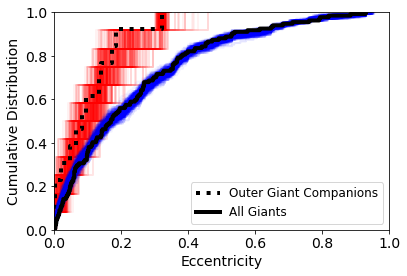

In [63]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

for i in np.arange(500):
    eccs = eccentricity_chains_outer[:, np.random.randint(0, 499)]
    hist, edges = np.histogram(eccs, normed=True, bins=4*len(outies))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(outies.e_med, normed=True, bins=4*len(outies))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Outer Giant Companions')

for i in np.arange(500):
    eccs = eccentricity_chains_all[:, np.random.randint(0, 499)]
    hist, edges = np.histogram(eccs, normed=True, bins=4*len(planets))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(planets.query('mass >= 0.1').e_med, normed=True, bins=4*len(planets))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='All Giants')

#ax.set_xscale('log')
ax.set_xlim([0, 1  ])
ax.set_ylim([0, 1])
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/cumulative_eccentricity.pdf', bbox_inches='tight')

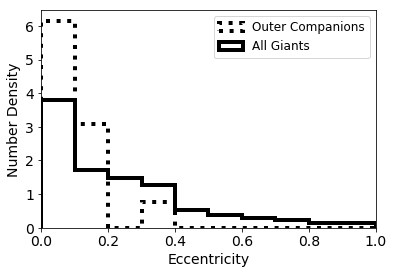

In [145]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
'''
for i in np.arange(1000):
    eccs = eccentricity_chains_outer[:, np.random.randint(0, 499)]
    ax.hist(eccs, color='red', lw=2, alpha=0.02, bins=10, range=(0, 0.5),
            histtype='step', density=True,label='_nolegend_')    
'''
ax.hist(outies.e_mode, color='black', lw=4, ls=':', bins=10, range=(0, 1),
        histtype='step', density=True,label='Outer Companions') 
'''
for i in np.arange(1000):
    eccs = eccentricity_chains_all[:, np.random.randint(0, 499)]
    ax.hist(eccs, color='blue', lw=2, alpha=0.02, bins=10, range=(0, 1),
            histtype='step', density=True, label='_nolegend_')   
'''    
ax.hist(giants.e_mode, color='black', lw=4, bins=10, range=(0, 1),
        histtype='step', density=True,label='All Giants') 

#ax.set_xscale('log')
ax.set_xlim([0, 1  ])
#ax.set_ylim([0, 1])
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Number Density')
ax.legend(fontsize=12)

fig.savefig('plots/histogram_eccentricity.pdf', bbox_inches='tight')

In [17]:
num_inner_hosts = len(np.unique(supers.hostname))
print(num_inner_hosts)

29


In [22]:
outerbins = lngrid(0.23, 10., 30., 2000, 3, 3) 
hierarchical_outer = Hierarchy(samples_outers, completey_small, bins=outerbins,
                               chainname='occur_chains/occur_chains_outer_testy.csv')
hierarchical_outer.max_like()

In [23]:
hierarchical_outer.sample()

100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


In [20]:
outerbinsone = np.array([[[-1.46967597, 1.04516474], \
                         [4.80109907, 7.60090246]]])
hierarchical_warm_one = Hierarchy(samples_outers, completey_small, bins=outerbinsone, lenrun=20000,
                                  chainname='occur_chains/occur_chains_warm_one.csv')
hierarchical_warm_one.max_like()

In [21]:
hierarchical_warm_one.sample()

100%|██████████| 20000/20000 [07:15<00:00, 45.90it/s]


In [24]:
chains_db = pd.read_csv('occur_chains/occur_chains_outer_3x3.csv')

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(len(chains_db.columns) - 1):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0) 
a_chains *= hierarchical_outer.bin_areas[0][0]*(100/num_inner_hosts)

a_chains_mass_outer = np.array([a_chains[0] + a_chains[1] + a_chains[2],
                                a_chains[3] + a_chains[4] + a_chains[5],
                                a_chains[6] + a_chains[7] + a_chains[8],])

In [25]:
modes     = np.zeros([3, 3])
sixtys    = np.zeros([3, 3])
quartiles = np.zeros([3, 3, 3])
zeros     = np.zeros([3, 3], dtype=bool)

In [26]:
for n in np.arange(9):
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0] = np.percentile(a_chains[n], 15.9)
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1] = np.percentile(a_chains[n], 50.0)
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2] = np.percentile(a_chains[n], 84.1)
    sixtys[np.mod(n, 3), np.floor_divide(n, 3)]       = np.percentile(a_chains[n], 68.2)
    
    hist, bin_edges = np.histogram(a_chains[n], bins=25, range=(np.percentile(a_chains[n],0.1), 
                                                                np.percentile(a_chains[n],68.3)))
    modes[np.mod(n, 3), np.floor_divide(n, 3)] = bin_edges[np.argmax(hist)]
    if modes[np.mod(n, 3), np.floor_divide(n, 3)] < quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0]:
        zeros[np.mod(n, 3), np.floor_divide(n, 3)] = True

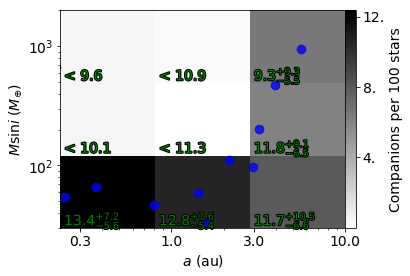

In [32]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.set_xlim([0.23, 10])
ax.set_ylim([30, 2000])
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.3, 1, 3, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

X = np.unique(np.exp(outerbins[:, 0]))
Y = np.unique(np.exp(outerbins[:, 1]))
C = modes.T

CS = ax.pcolormesh(X, Y, C, cmap=plt.cm.gray_r)
cbar = fig.colorbar(mappable=CS, pad=0, ticks=[4, 8, 12, 16], label='Companions per 100 stars')
cbar.ax.set_yticklabels(['4.', '8.', '12.', '16.'])
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, c='blue', s=75, alpha=0.8) 

for n in np.arange(9):
    a = X[np.mod(n, 3)]
    m = Y[np.floor_divide(n, 3)]
    xy = np.array([a, m])
    
    if not zeros[np.mod(n, 3), np.floor_divide(n, 3)]:
        mode = np.round(modes[np.mod(n, 3), np.floor_divide(n, 3)], decimals=1)
        med  = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1], decimals=1)
        minus = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1] - \
                         quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0], decimals=1)
        plus = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2] - \
                        quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1], decimals=1)
        txt = r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(med, plus, minus) + r'$'
    else:
        txt = '< ' + str(np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2], decimals=1))

    text = ax.annotate(txt, xy=xy, xytext=1.05*xy, color='green')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                           path_effects.Normal()])
    
fig.savefig('plots/checkerboard_pair_outer_3x3.pdf', bbox_inches='tight')

### Compare warm giant occurrence to not-warm-giant occurrence.

In [27]:
factor = hierarchical_outer.bin_areas[0][0]*(100/num_inner_hosts)
occurrence_cold = np.concatenate((a_chains[0], a_chains[1], a_chains[2], a_chains[5], a_chains[8]))/factor
occurrence_warm = np.concatenate((a_chains[3], a_chains[4], a_chains[6], a_chains[7]))/factor

In [32]:
chains_warm_one = pd.read_csv('occur_chains/occur_chains_warm_one.csv').gamma0

factor = hierarchical_outer.bin_areas[0][0]*(100/num_inner_hosts)
occurrence_cold_avg = (a_chains[0] + a_chains[1] + a_chains[2] + a_chains[5] + a_chains[8])/(5*factor)
occurrence_warm_avg = chains_warm_one

In [41]:
occurrence_warm_tot = occurrence_cold_avg*4*factor
np.percentile(occurrence_warm_tot, 95)

82.08248750968119

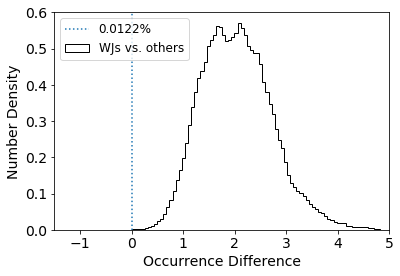

In [42]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

diff = (occurrence_cold_avg[np.random.randint(low=0, high=len(occurrence_cold_avg), size=10**6)] - \
        occurrence_warm_avg[np.random.randint(low=0, high=len(occurrence_warm_avg), size=10**6)])

ax.hist(diff, bins=100, histtype='step', color='black', density=True, label='WJs vs. others')
ax.axvline(0, ls=':', label='{}%'.format(scipy.stats.percentileofscore(diff, 0)))

#ax.set_xlim([-40, 60])
ax.set_xlim([-1.5, 5])
ax.set_xlabel(r'Occurrence Difference')
ax.set_ylabel('Number Density')
ax.legend(fontsize=12, loc=2)
fig.savefig('plots/warm_other_difference_avg.pdf', bbox_inches='tight')

In [23]:
outerbins = lngrid(0.23, 10., 30., 2000, 3, 3) 
hierarchical_outer_all = Hierarchy(samples_outers_all, completey_all, bins=outerbins)
hierarchical_outer_all.max_like()

In [25]:
hierarchical_outer_all.sample(parallel=True)

100%|██████████| 1000/1000 [36:00<00:00,  2.16s/it]


In [24]:
chains_db = pd.read_csv('occur_chains/occur_chains_outer_all_3x3.csv')
a_chains = np.empty((0, len(chains_db)))
for n in np.arange(len(chains_db.columns) - 1):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0) 
a_chains *= hierarchical_outer.bin_areas[0][0]*(100/719)

a_chains_mass = np.array([a_chains[0] + a_chains[1] + a_chains[2],
                          a_chains[3] + a_chains[4] + a_chains[5],
                          a_chains[6] + a_chains[7] + a_chains[8],])

NameError: name 'hierarchical_outer' is not defined

## Extract percentiles from posteriors, reshape for grid plots.

In [82]:
modes     = np.zeros([3, 3])
sixtys    = np.zeros([3, 3])
quartiles = np.zeros([3, 3, 3])
zeros     = np.zeros([3, 3], dtype=bool)

In [83]:
for n in np.arange(9):
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0] = np.percentile(a_chains[n], 15.9)
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1] = np.percentile(a_chains[n], 50.0)
    quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2] = np.percentile(a_chains[n], 84.1)
    sixtys[np.mod(n, 3), np.floor_divide(n, 3)]       = np.percentile(a_chains[n], 68.2)
    
    hist, bin_edges = np.histogram(a_chains[n], bins=25, range=(np.percentile(a_chains[n],0.1), 
                                                                np.percentile(a_chains[n],68.3)))
    modes[np.mod(n, 3), np.floor_divide(n, 3)] = bin_edges[np.argmax(hist)]
    if modes[np.mod(n, 3), np.floor_divide(n, 3)] < quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0]:
        zeros[np.mod(n, 3), np.floor_divide(n, 3)] = True


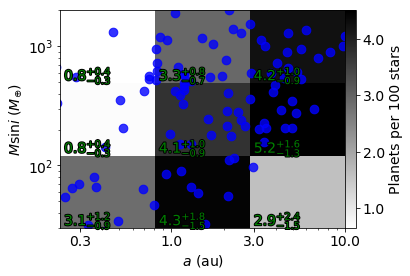

In [57]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.set_xlim([0.23, 10])
ax.set_ylim([30, 2000])
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.3, 1, 3, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

X = np.unique(np.exp(outerbins[:, 0]))
Y = np.unique(np.exp(outerbins[:, 1]))
C = modes.T

CS = ax.pcolormesh(X, Y, C, cmap=plt.cm.gray_r)
#plt.colorbar(mappable=CS, pad=0, label='Planets per 100 stars')
cbar = fig.colorbar(mappable=CS, pad=0, ticks=[1, 2, 3, 4], label='Planets per 100 stars')
cbar.ax.set_yticklabels(['1.0', '2.0', '3.0', '4.0'])
ax.scatter(planets.axis, 317.8*planets.mass, c='blue', s=75, alpha=0.8) 

for n in np.arange(9):
    a = X[np.mod(n, 3)]
    m = Y[np.floor_divide(n, 3)]
    xy = np.array([a, m])
    
    if not zeros[np.mod(n, 3), np.floor_divide(n, 3)]:
        mode = np.round(modes[np.mod(n, 3), np.floor_divide(n, 3)], decimals=1)
        med  = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1], decimals=1)
        minus = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1] - \
                         quartiles[np.mod(n, 3), np.floor_divide(n, 3), 0], decimals=1)
        plus = np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2] - \
                        quartiles[np.mod(n, 3), np.floor_divide(n, 3), 1], decimals=1)
        txt = r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(med, plus, minus) + r'$'
        #txt = np.round(modes[np.mod(n, 3), np.floor_divide(n, 3)], decimals=2)
    else:
        txt = '< ' + str(np.round(quartiles[np.mod(n, 3), np.floor_divide(n, 3), 2], decimals=1))

    text = ax.annotate(txt, xy=xy, xytext=1.05*xy, color='green')#, size='x-large'
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                           path_effects.Normal()])
    
fig.savefig('plots/checkerboard_3x3.pdf', bbox_inches='tight')

In [229]:
mlsum = np.sum(hierarchical_outer_all.mlvalues[:, 0])*hierarchical_outer.bin_areas[0][0]*(100/719)
mcsum = np.sum(modes)
print(mlsum, mcsum)

44.31712876287131 46.543318100377654


## Convert these grids into mass functions.

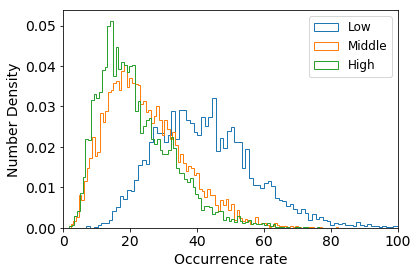

In [101]:
fig, ax = plt.subplots()
ax.hist(a_chains_mass[0], bins=100, histtype='step', density=True, label='Low')
ax.hist(a_chains_mass[1], bins=100, histtype='step', density=True, label='Middle')
ax.hist(a_chains_mass[2], bins=100, histtype='step', density=True, label='High')
ax.set_xlim([0, 100])
ax.set_xlabel('Occurrence rate')
ax.set_ylabel('Number Density')
ax.legend(fontsize=12)

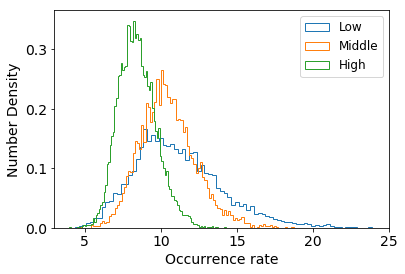

In [99]:
fig, ax = plt.subplots()
ax.hist(a_chains_mass_outer[0], bins=100, histtype='step', density=True, label='Low')
ax.hist(a_chains_mass_outer[1], bins=100, histtype='step', density=True, label='Middle')
ax.hist(a_chains_mass_outer[2], bins=100, histtype='step', density=True, label='High')
ax.set_xlim([3, 25])
ax.set_xlabel('Occurrence rate')
ax.set_ylabel('Number Density')
ax.legend(fontsize=12)

In [121]:
all_modes = np.zeros(3)
all_minus = np.zeros(3)
all_plus  = np.zeros(3)

outer_modes = np.zeros(3)
outer_minus = np.zeros(3)
outer_plus  = np.zeros(3)

for n in np.arange(3):
    all_minus[n] = np.percentile(a_chains_mass[n], 15.9)
    all_plus[n]  = np.percentile(a_chains_mass[n], 84.1)
    hist, bin_edges = np.histogram(a_chains_mass[n], bins=25, 
                                   range=(np.percentile(a_chains_mass[n],15.9), 
                                          np.percentile(a_chains_mass[n],84.1)))
    all_modes[n] = bin_edges[np.argmax(hist)]

    outer_minus[n] = np.percentile(a_chains_mass_outer[n], 15.9)
    outer_plus[n]  = np.percentile(a_chains_mass_outer[n], 84.1)
    hist, bin_edges = np.histogram(a_chains_mass_outer[n], bins=25, 
                                   range=(np.percentile(a_chains_mass_outer[n],15.9), 
                                          np.percentile(a_chains_mass_outer[n],84.1)))
    outer_modes[n] = bin_edges[np.argmax(hist)]

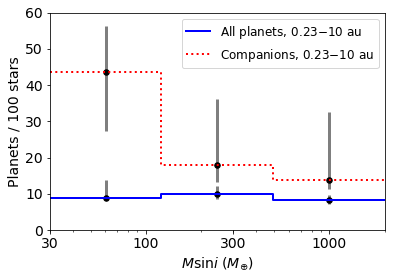

In [144]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((30, 100, 300, 1000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

edges = np.unique(outerbins[:, 1])
width = edges[1] - edges[0]

ax.scatter(np.exp(edges[:-1] + 0.5*width), all_modes,
           color='black', s=30, label='_nolegend_')
ax.vlines(np.exp(edges[:-1] + 0.5*width), all_minus,
          all_plus, alpha=0.5, color='black', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(edges[:-1] + width), 0, np.exp(edges[0])), 
        np.insert(all_modes, 0, all_modes[0]),
        color='blue', lw=2, label=r'All planets, 0.23$-$10 au')

ax.scatter(np.exp(edges[:-1] + 0.5*width), outer_modes,
           color='black', s=30, label='_nolegend_')
ax.vlines(np.exp(edges[:-1] + 0.5*width), outer_minus,
          outer_plus, alpha=0.5, color='black', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(edges[:-1] + width), 0, np.exp(edges[0])), 
        np.insert(outer_modes, 0, outer_modes[0]), linestyle=':',
        color='red', lw=2, label=r'Companions, 0.23$-$10 au')

ax.set_xlim(np.exp([edges[0], edges[-1]]))
ax.set_ylim([0, 60])

ax.set_xlabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_ylabel('Planets / 100 stars')

ax.legend(fontsize=12)

fig.savefig('plots/companions_mass_functions.pdf', bbox_inches='tight')

## Estimate fraction of cold giants that host an inner planet. Start with the whole box.

### Remake small planet samples with only the first-discovered planet in each system.

In [24]:
samples_small = pd.read_csv('../legacy_samples/samples_small.csv').sample(500).reset_index(drop=True)

good_cols = [col for col in samples_small.columns if '_a' in col or '_M' in col]
samples_small = samples_small[good_cols]
samples_med = samples_small.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_small.columns]) 

first_cols = []
for system in np.unique([x[:-1] for x in planetnames]):
    ps = [planet for planet in planetnames if system in planet]
    n       = len(ps)
    first   = ps[0]
    a_col = first[:-2] + '_a' + first[-1]
    M_col = first[:-2] + '_M' + first[-1]
    first_cols.append(a_col)
    first_cols.append(M_col)

# Trim out planets that don't belong in each sample.
columns_inner_all = [col for col in first_cols if col[:-3] in list(all_outers.hostname)]

samples_small_first = samples_small[first_cols]
samples_first_inner = samples_small[columns_inner_all]

for col in first_cols:
    if '_M' in col:
        samples_small_first[col] *= 317.8
        
for col in columns_inner_all:
    if '_M' in col:
        samples_first_inner[col] *= 317.8

In [25]:
nsuperstars = len(np.unique(supers.hostname))
nouterstars = len(np.unique(planets.query('axis > 0.23 and mass >= 30/317.8 and axis < 10 and mass < 6000/317.8').hostname))
print(nsuperstars, nouterstars)

29 78


## Estimate P(Small Inner Planet | Outer Giant) .

In [26]:
# CHANGED FROM 1 AU TO 0.5 AU
hierarchical_inner = Hierarchy(samples_first_inner, completey_outer, 
                               fraction=True, nstars=nouterstars,
                               chainname='occur_chains/occur_chains_fraction_IO_final.csv',
                               bins=np.array([[[np.log(0.023), np.log(1)], 
                                               [np.log(2.), np.log(30)]]]))
hierarchical_inner.max_like()

In [24]:
hierarchical_inner.mlvalues*hierarchical_inner.bin_areas[0][0]/nouterstars

array([[0.31104815, 0.11756515]])

In [31]:
hierarchical_inner.mlvalues*hierarchical_inner.bin_areas[0][0]/nouterstars

array([[0.37252984, 0.14080304]])

In [27]:
hierarchical_inner.sample()

100%|██████████| 1000/1000 [00:22<00:00, 45.05it/s]


In [26]:
post = hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars
print(np.median(post), '+', np.percentile(post, 84.1) - np.median(post), '-', np.median(post) - np.percentile(post, 15.9))

0.36841203198964234 + 0.14869297916795543 - 0.1119293575517391


In [34]:
print(np.median(hierarchical_inner.chains)*hierarchical_inner.bin_areas[0][0]/nouterstars,
  '+/-', np.std(hierarchical_inner.chains)*hierarchical_inner.bin_areas[0][0]/nouterstars)

0.4025840857627639 +/- 0.153233393281934


In [52]:
len(columns_inner_all)/2/nouterstars

0.1038961038961039

In [53]:
0.396/0.09876

4.0097205346294045

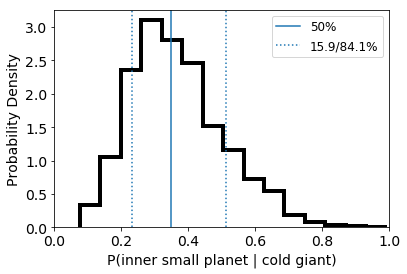

In [44]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars
ax.hist(chain, histtype='step', color='black', lw=4, bins=15, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.set_xlabel('P(inner small planet | cold giant)')
ax.set_ylabel('Probability Density')
ax.set_xlim([0, 1])
ax.legend(fontsize=12)
fig.savefig('plots/fraction_IO_simple_05.pdf', bbox_inches='tight')

## Estimate P(Small Inner Planet) .

In [28]:
hierarchical_small_fraction = Hierarchy(samples_small_first, completey_all, 
                                        fraction=True, nstars=719,
                                        chainname='occur_chains/occur_chains_fraction_I_05.csv',
                                        bins=np.array([[[np.log(0.023), np.log(1)], 
                                                        [np.log(2.), np.log(30)]]]))
hierarchical_small_fraction.max_like()

In [46]:
hierarchical_small_fraction.mlvalues*hierarchical_small_fraction.bin_areas[0][0]/719

array([[0.21387468, 0.04277494]])

In [29]:
hierarchical_small_fraction.sample()

100%|██████████| 1000/1000 [00:52<00:00, 19.18it/s]


In [48]:
# 0.5 au
print(np.median(hierarchical_small_fraction.chains)*hierarchical_small_fraction.bin_areas[0][0]/719,
  '+/-', np.std(hierarchical_small_fraction.chains)*hierarchical_small_fraction.bin_areas[0][0]/719)

0.22358731790505917 +/- 0.04451238638698792


In [58]:
print(np.median(hierarchical_small_fraction.chains)*hierarchical_small_fraction.bin_areas[0][0]/719,
  '+/-', np.std(hierarchical_small_fraction.chains)*hierarchical_small_fraction.bin_areas[0][0]/719)

0.2757821982768615 +/- 0.05425677565788086


In [59]:
len(first_cols)/2/719

0.04033379694019471

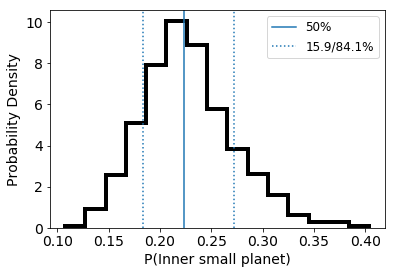

In [49]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_small_fraction.chains*hierarchical_small_fraction.bin_areas[0][0]/719
ax.hist(chain, histtype='step', color='black', lw=4, bins=15, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.set_xlabel('P(Inner small planet)')
ax.set_ylabel('Probability Density')
ax.legend(fontsize=12)
fig.savefig('plots/fraction_I_simple_05.pdf', bbox_inches='tight')

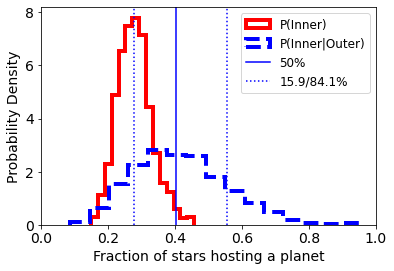

In [56]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_small_fraction.chains*hierarchical_small_fraction.bin_areas[0][0]/719
ax.hist(chain, histtype='step', color='red', lw=4, bins=15, \
        density=True, label='P(Inner)')

chain = hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars
ax.hist(chain, histtype='step', color='blue', lw=4, bins=15, 
        density=True, ls='--', label='P(Inner|Outer)')
ax.axvline(np.percentile(chain, 50), color='blue', label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', color='blue', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', color='blue', label='__nolegend__')

ax.set_xlim([0, 1])
ax.set_xlabel('Fraction of stars hosting a planet')
ax.set_ylabel('Probability Density')
ax.legend(fontsize=12)

fig.savefig('plots/fraction_I_IO.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/fraction_I_IO.pdf', bbox_inches='tight')

### Estimate P(Outer Giant | Inner small planet) .

In [43]:
outernames = np.unique([x[:-2] + x[-1] for x in samples_outers.columns]) 
first_cols_outer = []
for system in np.unique([x[:-1] for x in outernames]):
    ps = [planet for planet in outernames if system in planet]
    n       = len(ps)
    first   = ps[0]
    a_col = first[:-2] + '_a' + first[-1]
    M_col = first[:-2] + '_M' + first[-1]
    first_cols_outer.append(a_col)
    first_cols_outer.append(M_col)
    
samples_outers_all
outernames_all = np.unique([x[:-2] + x[-1] for x in samples_outers_all.columns]) 
first_cols_outer_all = []
for system in np.unique([x[:-1] for x in outernames_all]):
    ps = [planet for planet in outernames_all if system in planet]
    n       = len(ps)
    first   = ps[0]
    a_col = first[:-2] + '_a' + first[-1]
    M_col = first[:-2] + '_M' + first[-1]
    first_cols_outer_all.append(a_col)
    first_cols_outer_all.append(M_col)

# Trim out planets that don't belong in each sample.
columns_outer_comp = [col for col in first_cols_outer if col[:-3] in list(supers.hostname)]
samples_first_outer_comp = samples_outers[columns_outer_comp]
samples_first_outer_all  = samples_outers_all[first_cols_outer_all]

In [44]:
hierarchical_outer_fraction = Hierarchy(samples_first_outer_comp, completey_small, 
                                        fraction=True, nstars=nsuperstars,
                                        chainname='occur_chains/occur_chains_fraction_OI.csv',
                                        bins=np.array([[[np.log(0.23), np.log(10)], 
                                                        [np.log(30), np.log(6000)]]]))
hierarchical_outer_fraction.max_like()

In [63]:
hierarchical_outer_fraction.mlvalues*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars

array([[0.36317107, 0.12840036]])

In [45]:
hierarchical_outer_fraction.sample()

100%|██████████| 1000/1000 [00:24<00:00, 40.66it/s]


In [65]:
print(np.median(hierarchical_outer_fraction.chains)*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars,
  '+/-', np.std(hierarchical_outer_fraction.chains)*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars)

0.40572067558457536 +/- 0.14102758461026144


In [66]:
len(columns_outer_comp)/2/nsuperstars

0.2962962962962963

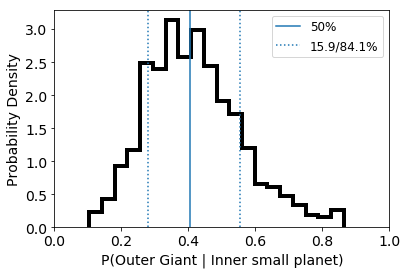

In [67]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_outer_fraction.chains*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars
ax.hist(chain, histtype='step', color='black', lw=4, bins=20, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.legend(fontsize=12)
ax.set_xlabel('P(Outer Giant | Inner small planet)')
ax.set_ylabel('Probability Density')
ax.set_xlim([0, 1])
fig.savefig('plots/fraction_OI_simple.pdf', bbox_inches='tight')

### Estimate P(Outer Giant) .

In [46]:
coldbins = lngrid(0.23, 10., 30., 6000, 1, 1) 
hierarchical_outer_fraction_all = Hierarchy(samples_first_outer_all, completey_all, 
                                            chainname='occur_chains/occur_chains_fraction_O.csv',
                                            fraction=True, nstars=719,
                                            bins=coldbins)
hierarchical_outer_fraction_all.max_like()

In [47]:
hierarchical_outer_fraction_all.sample()

100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


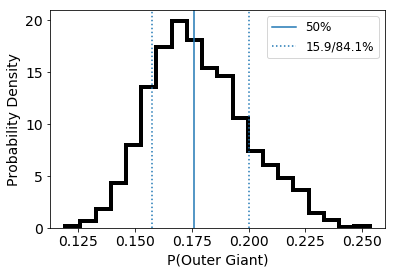

In [75]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_outer_fraction_all.chains*hierarchical_outer_fraction_all.bin_areas[0][0]/719
ax.hist(chain, histtype='step', color='black', lw=4, bins=20, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.legend(fontsize=12)
ax.set_xlabel('P(Outer Giant)')
ax.set_ylabel('Probability Density')
fig.savefig('plots/fraction_O_simple.pdf', bbox_inches='tight')

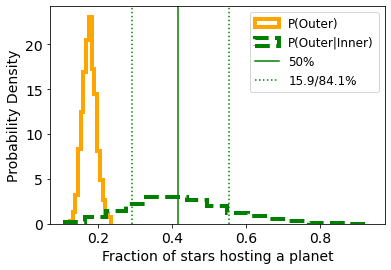

In [57]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_outer_fraction_all.chains*hierarchical_outer_fraction_all.bin_areas[0][0]/719
ax.hist(chain, histtype='step', color='orange', lw=4, bins=15, \
        density=True, label='P(Outer)')

chain = hierarchical_outer_fraction.chains*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars
ax.hist(chain, histtype='step', color='green', lw=4, bins=15, 
        density=True, ls='--', label='P(Outer|Inner)')
ax.axvline(np.percentile(chain, 50), color='green', label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', color='green', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', color='green', label='__nolegend__')

ax.set_xlabel('Fraction of stars hosting a planet')
ax.set_ylabel('Probability Density')
ax.legend(fontsize=12)

fig.savefig('plots/fraction_O_OI.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/fraction_O_OI.pdf', bbox_inches='tight')

In [68]:
len(first_cols_outer_all)/2/719

0.1168289290681502

### First crack at Bayesian inference. P(I|O) = P(O|I) * P(I) / P(O)

In [76]:
P_O_I = hierarchical_outer_fraction.chains*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars
P_O   = hierarchical_outer_fraction_all.chains*hierarchical_outer_fraction_all.bin_areas[0][0]/719
P_I   = hierarchical_small_fraction.chains*hierarchical_small_fraction.bin_areas[0][0]/719

In [77]:
print(len(P_O_I), len(P_O), len(P_I))

3600 3600 3600


In [78]:
P_I_O = P_O_I * P_I / P_O

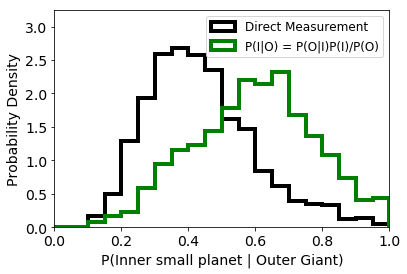

In [79]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.hist(hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars,
        histtype='step', color='black', lw=4, bins=20, density=True, 
        range=[0, 1], label='P(I|O) (Direct)')
ax.hist(P_I_O, histtype='step', color='green', lw=4, bins=20, 
        range=[0, 1], density=True, label='P(I|O) = P(O|I)P(I)/P(O)')
ax.set_xlabel('P(Inner small planet | Outer Giant)')
ax.set_ylabel('Probability Density')
ax.set_xlim([0, 1])
ax.set_ylim([0, 3.25])
ax.legend(fontsize=12)
fig.savefig('plots/fraction_IO_simple.pdf', bbox_inches='tight')

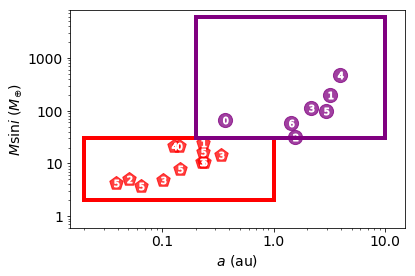

In [42]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.set_xlim([0.015, 15])
ax.set_ylim([0.6, 8000])
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

xin = [0.02, 1]
yin = [2, 30]
xout = [0.2, 10]
yout = [30, 6000]

pair_inner_boring = pair_inner.query('hostname!="75732" and hostname!="gl876"')
pair_outer_boring = pair_outer.query('hostname!="75732" and hostname!="gl876"')

ax.scatter(pair_inner_boring.axis, 317.8*pair_inner_boring.mass, c='r', s=200, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer_boring.axis, 317.8*pair_outer_boring.mass, s=200, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))

ax.add_patch(Rectangle((xin[0], yin[0]), xin[1]-xin[0], yin[1]-yin[0], lw=4, color='red', fill=False))
ax.add_patch(Rectangle((xout[0], yout[0]), xout[1]-xout[0], yout[1]-yout[0], lw=4, color='purple', fill=False))

names = np.unique(pair_inner_boring.hostname)
for i in range(len(names)):
    thisname = names[i]
    ax.scatter(pair_inner_boring.query('hostname == @thisname').axis,
               317.8*pair_inner_boring.query('hostname == @thisname').mass, s=50,
               marker=r"$ {} $".format(i), color='white', label='__nolegend__') 
    ax.scatter(pair_outer_boring.query('hostname == @thisname').axis, 
               317.8*pair_outer_boring.query('hostname == @thisname').mass, s=50,
               marker=r"$ {} $".format(i), color='white', label='__nolegend__') 

fig.savefig('plots/boxes_simple.pdf', bbox_inches='tight')

### Redo with Marta's boxes. 0.5 - 20 MJup, 1 - 20 AU. Maybe try the 10 Earth mass cut too.

### Redo with "Marta Wittenmyer's" boxes. 0.3 - 13 MJup, 3 - 7 AU. Maybe try the 10 Earth mass cut too, but start with < 30 Earth masses.

In [53]:
samples_jupi = pd.read_csv('../legacy_samples/samples_jupiter.csv').sample(500).reset_index(drop=True)
columns = [col for col in samples_jupi.columns if ('_M' in col or '_a' in col)]
samples_jupi = samples_jupi[columns]

first_cols_jupi = []
planetnames = np.unique([x[:-2] + x[-1] for x in samples_jupi.columns]) 
for system in np.unique([x[:-1] for x in planetnames]):
    ps = [planet for planet in planetnames if system in planet]
    first   = ps[0]
    a_col = first[:-2] + '_a' + first[-1]
    M_col = first[:-2] + '_M' + first[-1]
    first_cols_jupi.append(a_col)
    first_cols_jupi.append(M_col)

samples_first_jupi = samples_jupi[first_cols_jupi]
for col in first_cols_jupi:
    if '_M' in col:
        samples_first_jupi[col] *= 317.8
        
jupi_outer_cols = []
for name in planetnames:
    a_col = name[:-2] + '_a' + name[-1]
    M_col = name[:-2] + '_M' + name[-1]
    if name[:-2] in list(supers.hostname):
        jupi_outer_cols.append(a_col)
        jupi_outer_cols.append(M_col)
        
samples_first_jupi_outer = samples_first_jupi[jupi_outer_cols]

In [88]:
hierarchical_outer_marta = Hierarchy(samples_first_jupi_outer, completey_small, 
                                        fraction=True, nstars=nsuperstars,
                                        chainname='occur_chains/occur_chains_fraction_OI_wittenbryan.csv',
                                        bins=np.array([[[np.log(3), np.log(7)], 
                                                        [np.log(0.3*317.8), 
                                                         np.log(13*317.8)]]]))
hierarchical_outer_marta.max_like()

In [89]:
hierarchical_outer_marta.mlvalues*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars

array([[0.09659922, 0.06830596]])

In [90]:
hierarchical_outer_marta.sample()

100%|██████████| 1000/1000 [00:13<00:00, 76.88it/s]


In [91]:
print(np.median(hierarchical_outer_marta.chains)*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars,
  '+/-', np.std(hierarchical_outer_marta.chains)*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars)

0.13271115230677688 +/- 0.07775959020338596


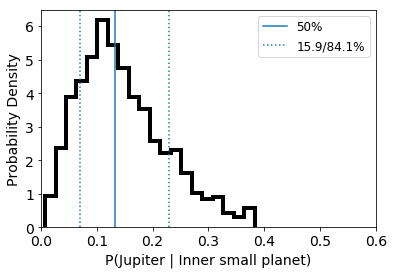

In [92]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_outer_marta.chains*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars
ax.hist(chain, histtype='step', color='black', lw=4, bins=20, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.legend(fontsize=12)
ax.set_xlabel('P(Jupiter | Inner small planet)')
ax.set_ylabel('Probability Density')
ax.set_xlim([0, 0.6])
fig.savefig('plots/fraction_OI_wittenbryan.pdf', bbox_inches='tight')

### Marta's Inner | Outer . Outer sample 0.3 - 13 MJup, 3 - 7 AU, inner 30 - 2 MEarth.

In [54]:
first_cols_marta = []
planetnames = np.unique([x[:-2] + x[-1] for x in samples_small.columns]) 
for system in np.unique([x[:-1] for x in planetnames]):
    ps = [planet for planet in planetnames if system in planet]
    n       = len(ps)
    first   = ps[0]
    a_col = first[:-2] + '_a' + first[-1]
    M_col = first[:-2] + '_M' + first[-1]
    first_cols_marta.append(a_col)
    first_cols_marta.append(M_col)
    
    
samples_med_outer = samples_outers_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_outers_all.columns]) 


# Trim out planets that don't belong in each sample.
columns_inner_all_marta = [col for col in first_cols_marta if col[:-3] in \
                           list(all_outers.query('axis >= 3 and axis < 7 and mass >= 0.3 and mass < 13').hostname)]

samples_first_inner_marta = samples_small[columns_inner_all_marta] 
for col in columns_inner_all_marta:
    if '_M' in col:
        samples_first_inner_marta[col] *= 317.8

In [55]:
nouterstars_marta = len(np.unique(all_outers.query('axis >= 3 and axis < 7 and mass >= 0.3 and mass < 13').hostname))
hierarchical_inner_marta = Hierarchy(samples_first_inner_marta, completey_jupiter, 
                                     chainname='occur_chains/occur_chains_fraction_IO_wittenbryan_05.csv',
                                     fraction=True, nstars=nouterstars_marta,
                                     bins=np.array([[[np.log(0.023), np.log(0.5)], 
                                                     [np.log(2.), np.log(30)]]]))
hierarchical_inner_marta.max_like()

In [56]:
samples_first_inner_marta

11964a_a2  11964a_M2  190360_a2  190360_M2  75732_a5  75732_M5
0     0.230451  22.121847   0.130443  21.863523  0.015987  9.939217
1     0.229049  22.903515   0.130549  21.454905  0.015537  9.110332
2     0.235220  24.595275   0.128858  21.494548  0.015954  9.766299
3     0.230306  23.939616   0.127895  19.633252  0.015590  8.836687
4     0.232552  25.844809   0.130243  22.142628  0.015847  9.284596
..         ...        ...        ...        ...       ...       ...
495   0.234246  26.027641   0.130537  23.300988  0.015891  9.605181
496   0.233470  25.578560   0.127875  21.146584  0.015875  9.499040
497   0.228683  27.653050   0.128929  21.771477  0.016177  9.900043
498   0.232159  22.058884   0.126588  20.124471  0.015484  8.653302
499   0.229935  21.608561   0.133054  21.946048  0.015537  9.189429

[500 rows x 6 columns]

In [96]:
nouterstars_marta

29

In [58]:
hierarchical_inner_marta.sample()

100%|██████████| 1000/1000 [00:13<00:00, 71.44it/s]


In [59]:
# 0.5 au
print(np.median(hierarchical_inner_marta.chains)*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta,
  '+/-', np.std(hierarchical_inner_marta.chains)*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta)

0.272931843957867 +/- 0.1615727713940967


In [98]:
print(np.median(hierarchical_inner_marta.chains)*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta,
  '+/-', np.std(hierarchical_inner_marta.chains)*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta)

0.3205176143684284 +/- 0.20114528002556495


In [99]:
len(samples_first_inner_marta.columns)/2/nouterstars_marta

0.10344827586206896

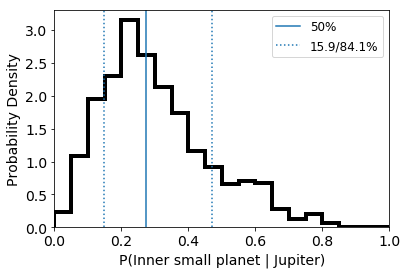

In [60]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_inner_marta.chains*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta
ax.hist(chain, histtype='step', color='black', lw=4, bins=20, density=True, range=[0, 1], label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.legend(fontsize=12)
ax.set_xlabel('P(Inner small planet | Jupiter)')
ax.set_ylabel('Probability Density')
ax.set_xlim([0, 1])
fig.savefig('plots/fraction_IO_wittenbryan_05.pdf', bbox_inches='tight')

### P(Outer).

In [102]:
jupbins  = lngrid(3., 7., 0.3*317.8, 13*317.8, 1, 1) 
hierarchical_outer_fraction_jupi = Hierarchy(samples_first_jupi, completey_all, 
                                             chainname='occur_chains/occur_chains_fraction_O_wittenbryan.csv',
                                             fraction=True, nstars=719,
                                             bins=jupbins)
hierarchical_outer_fraction_jupi.max_like()

In [103]:
hierarchical_outer_fraction_jupi.sample()

100%|██████████| 1000/1000 [00:45<00:00, 22.16it/s]


In [104]:
print(np.median(hierarchical_outer_fraction_jupi.chains)*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719,
  '+/-', np.std(hierarchical_outer_fraction_jupi.chains)*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719)

0.07190702474225641 +/- 0.013198333341103102


In [105]:
hierarchical_outer_fraction_jupi.mlvalues*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719

array([[0.06651898, 0.01257091]])

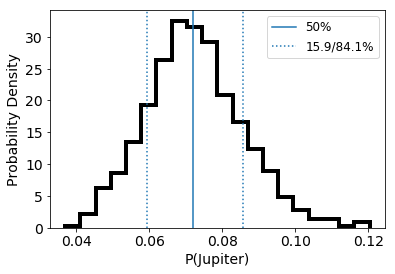

In [106]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
chain = hierarchical_outer_fraction_jupi.chains*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719
ax.hist(chain, histtype='step', color='black', lw=4, bins=20, density=True, label='__nolegend__')
ax.axvline(np.percentile(chain, 50), label='50%')
ax.axvline(np.percentile(chain, 15.9), ls=':', label='15.9/84.1%')
ax.axvline(np.percentile(chain, 84.1), ls=':', label='__nolegend__')
ax.legend(fontsize=12)
ax.set_xlabel('P(Jupiter)')
ax.set_ylabel('Probability Density')
fig.savefig('plots/fraction_O_wittenbryan.pdf', bbox_inches='tight')

### Do the Bayes thing again.

In [107]:
P_O_I = hierarchical_outer_marta.chains*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars
P_O   = hierarchical_outer_fraction_jupi.chains*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719
P_I   = hierarchical_small_fraction.chains*hierarchical_small_fraction.bin_areas[0][0]/719

In [108]:
P_I_O_wittenbryan = P_O_I * P_I / P_O

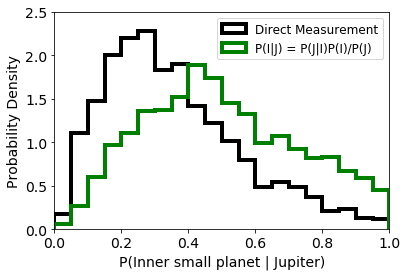

In [109]:
ranger = [0, 1]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.hist(hierarchical_inner_marta.chains*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta,
        histtype='step', color='black', lw=4, bins=20, density=True, 
        range=[0, 1], label='P(I|J) (Direct)')
ax.hist(P_I_O_wittenbryan, histtype='step', color='green', lw=4, bins=20, 
        density=True, range=ranger, label='P(I|J) = P(J|I)P(I)/P(J)')
ax.set_xlabel('P(Inner small planet | Jupiter)')
ax.set_ylabel('Probability Density')
ax.set_xlim(ranger)
ax.set_ylim([0, 2.5])
ax.legend(fontsize=12)
fig.savefig('plots/fraction_IO_wittenbryan.pdf', bbox_inches='tight')

In [110]:
chains = hierarchical_inner_marta.chains*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta
print(np.percentile(chains, 15.9), np.percentile(chains, 50), np.percentile(chains, 84.1))
print(np.percentile(chains, 50) - np.percentile(chains, 15.9), np.percentile(chains, 50), np.percentile(chains, 84.1) - np.percentile(chains, 50))

0.1605579121043419 0.3205176143684284 0.5613929149267878
0.1599597022640865 0.3205176143684284 0.24087530055835937


In [112]:
chains = hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars
print(np.percentile(chains, 15.9), np.percentile(chains, 50), np.percentile(chains, 84.1))
print(np.percentile(chains, 50) - np.percentile(chains, 15.9), np.percentile(chains, 50), np.percentile(chains, 84.1) - np.percentile(chains, 50))

0.28461207872947025 0.4171520231667131 0.5891383535235841
0.13253994443724287 0.4171520231667131 0.171986330356871


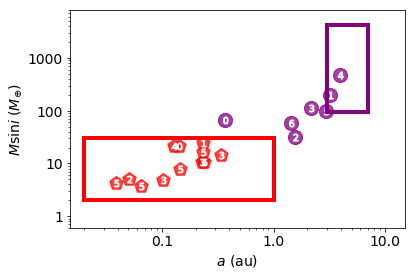

In [44]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.set_xlim([0.015, 15])
ax.set_ylim([0.6, 8000])
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

xin = [0.02, 1]
yin = [2, 30]
xout = [3, 7]
yout = [0.3*317.8, 13*317.8]

pair_inner_boring = pair_inner.query('hostname!="75732" and hostname!="gl876"')
pair_outer_boring = pair_outer.query('hostname!="75732" and hostname!="gl876"')

ax.scatter(pair_inner_boring.axis, 317.8*pair_inner_boring.mass, c='r', s=200, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer_boring.axis, 317.8*pair_outer_boring.mass, s=200, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))

#ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=200, alpha=0.75, 
#           label='{} inner small companions'.format(len(pair_inner)), marker='p')
#ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=200, c='purple', alpha=0.75, 
#           label='{} outer giant companions'.format(len(pair_outer)))

ax.add_patch(Rectangle((xin[0], yin[0]), xin[1]-xin[0], yin[1]-yin[0], lw=4, color='red', fill=False))
ax.add_patch(Rectangle((xout[0], yout[0]), xout[1]-xout[0], yout[1]-yout[0], lw=4, color='purple', fill=False))

names = np.unique(pair_inner_boring.hostname)
for i in range(len(names)):
    thisname = names[i]
    ax.scatter(pair_inner_boring.query('hostname == @thisname').axis,
               317.8*pair_inner_boring.query('hostname == @thisname').mass, s=50,
               marker=r"$ {} $".format(i), color='white', label='__nolegend__') 
    ax.scatter(pair_outer_boring.query('hostname == @thisname').axis, 
               317.8*pair_outer_boring.query('hostname == @thisname').mass, s=50,
               marker=r"$ {} $".format(i), color='white', label='__nolegend__') 

fig.savefig('plots/boxes_wittenbryan.pdf', bbox_inches='tight')

# Odds and ends.

## Run full sample.

In [21]:
gridbins = lngrid(0.03, 30., 30., 6000, 6, 3) 
hierarchical_grid = Hierarchy(samples_all, completey_all, bins=gridbins)
hierarchical_grid.max_like()

In [50]:
hierarchical_grid.sample(parallel=True)

100%|██████████| 1000/1000 [1:32:43<00:00,  5.56s/it]


In [22]:
chains_db = pd.read_csv('occur_chains_6x3.csv')
a_chains = np.empty((0, len(chains_db)))
for n in np.arange(len(chains_db.columns) - 1):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0) 
a_chains *= hierarchical_grid.bin_areas[0][0]*(100/719)

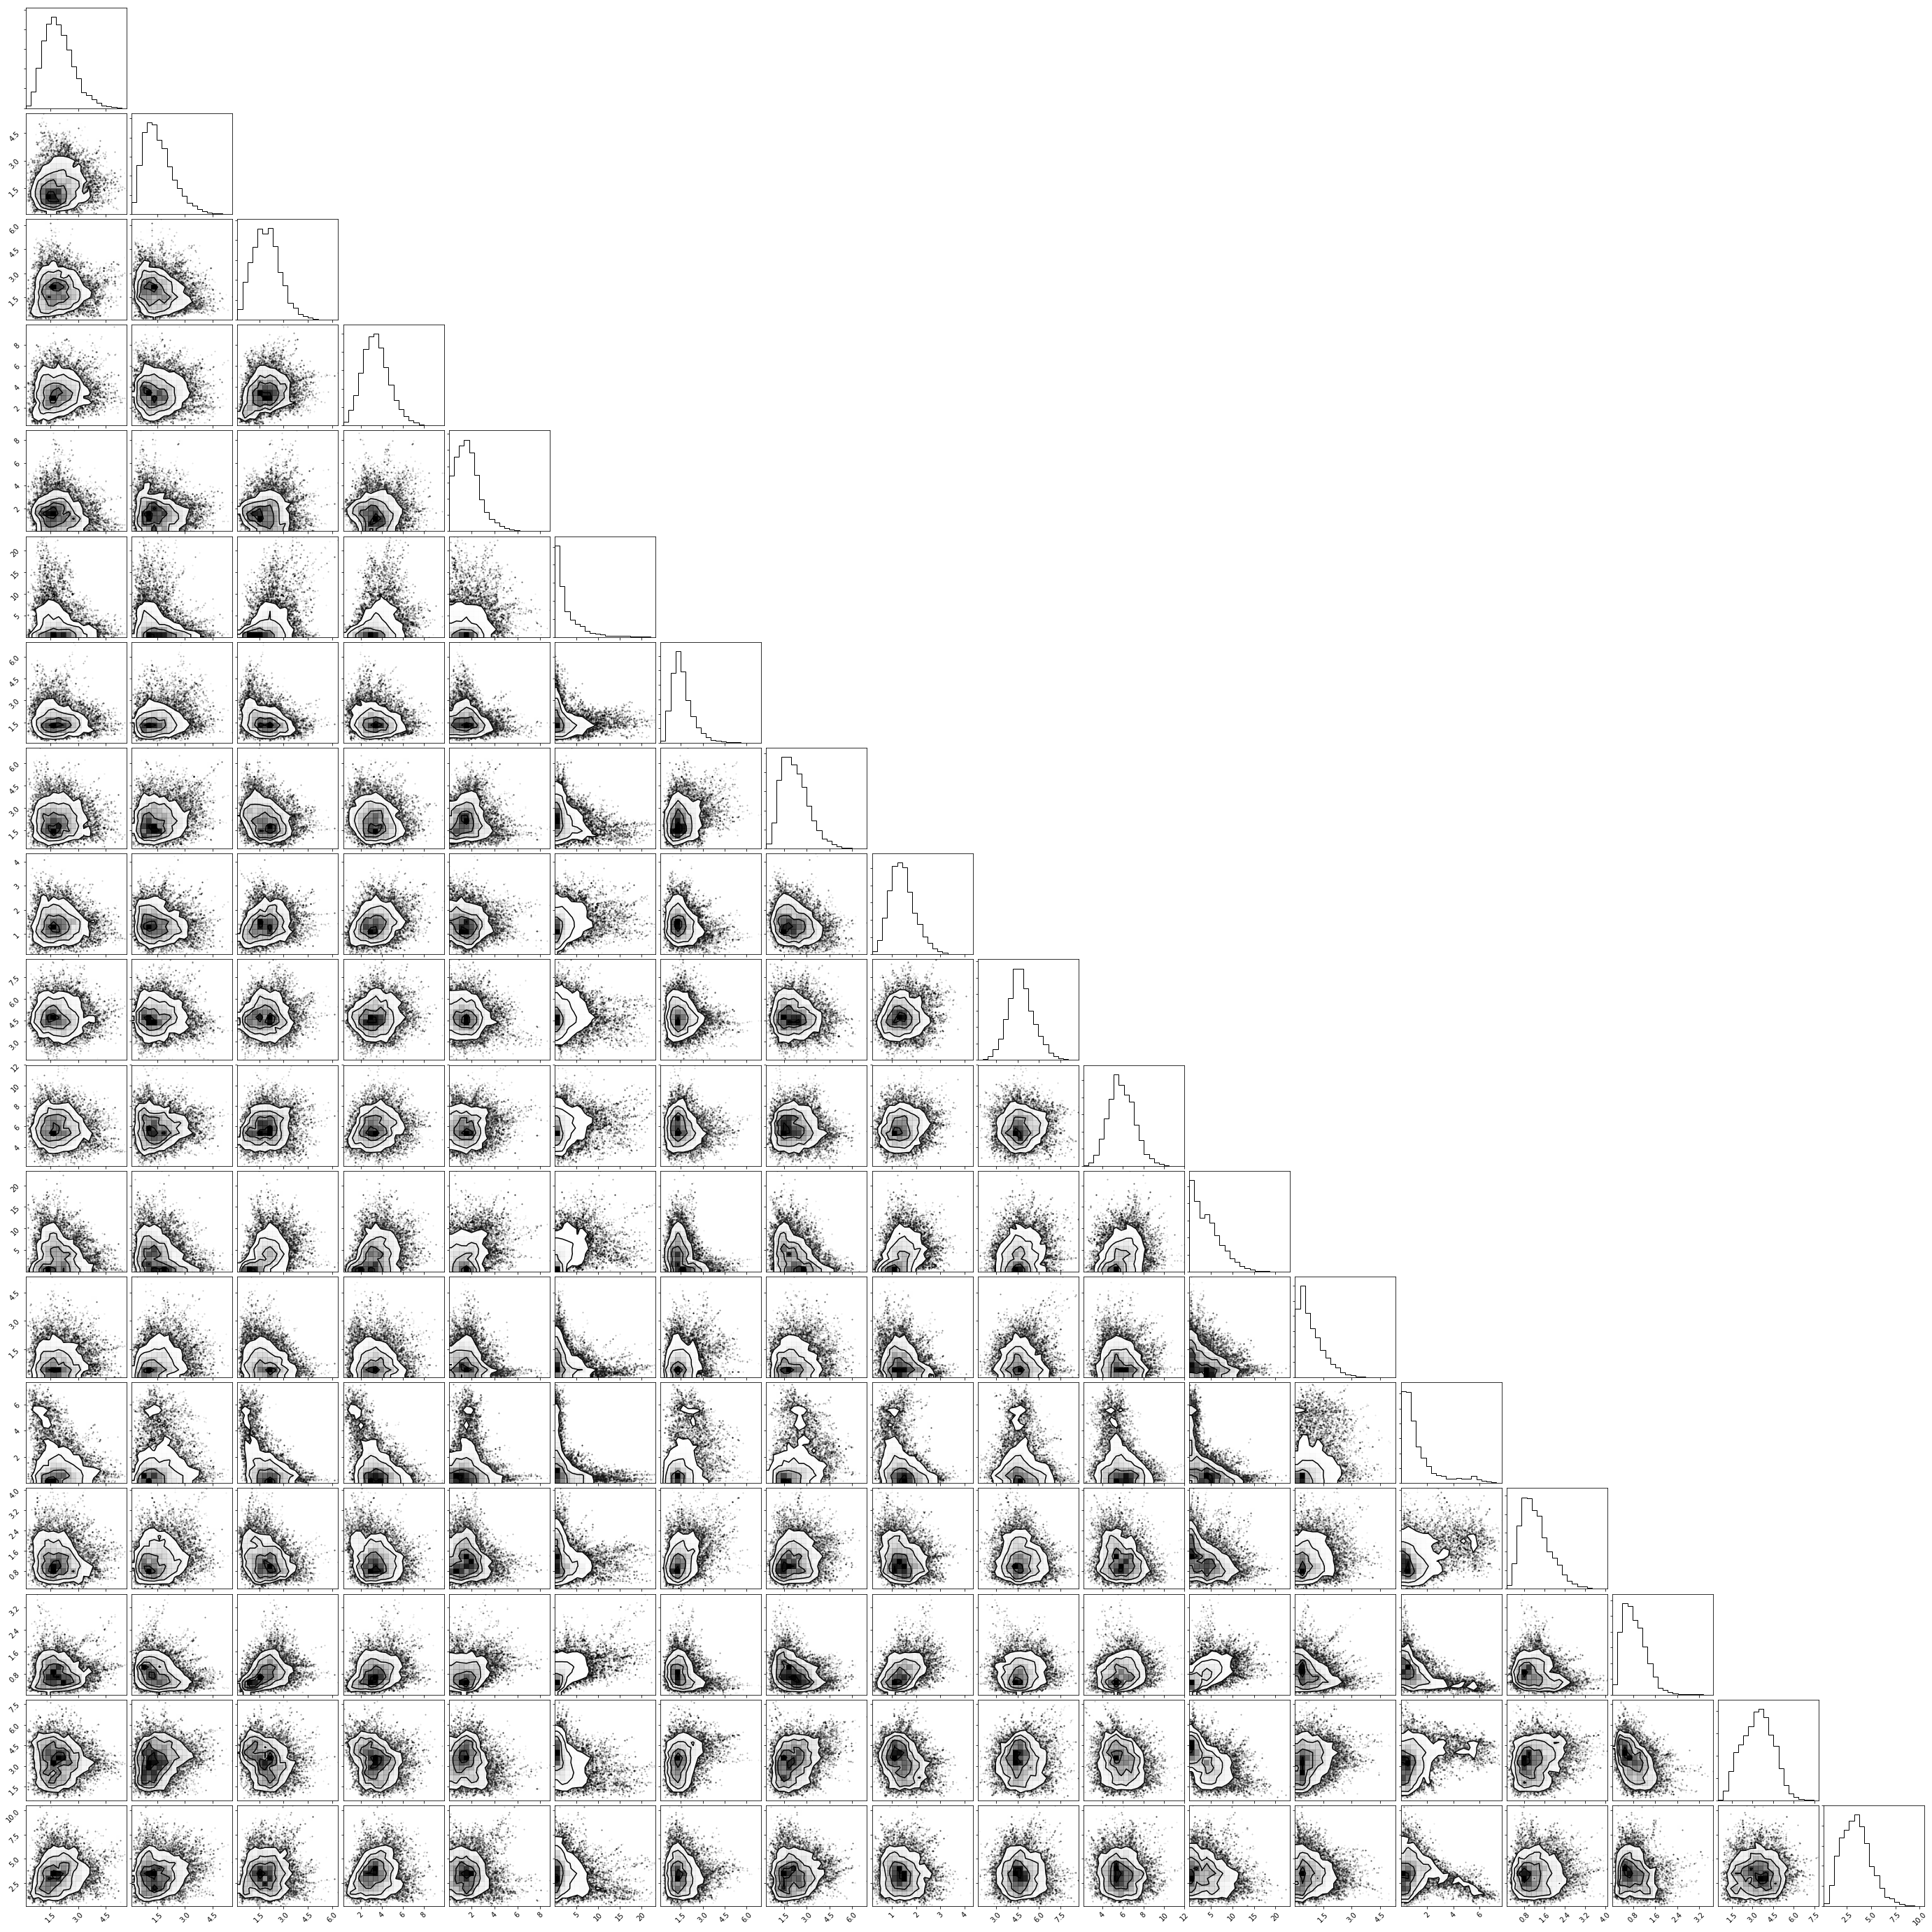

In [57]:
fig = corner.corner(a_chains.T)
fig.savefig('plots/corner_grid_6x3.pdf')

In [23]:
modes     = np.zeros([6, 3])
sixtys    = np.zeros([6, 3])
quartiles = np.zeros([6, 3, 3])
zeros     = np.zeros([6, 3], dtype=bool)

In [24]:
for n in np.arange(18):
    #print(np.mod(n, 6), np.floor_divide(n, 6))
    quartiles[np.mod(n, 6), np.floor_divide(n, 6), 0] = np.percentile(a_chains[n], 15.9)
    quartiles[np.mod(n, 6), np.floor_divide(n, 6), 1] = np.percentile(a_chains[n], 50.0)
    quartiles[np.mod(n, 6), np.floor_divide(n, 6), 2] = np.percentile(a_chains[n], 84.1)
    sixtys[np.mod(n, 6), np.floor_divide(n, 6)]       = np.percentile(a_chains[n], 68.2)
    
    hist, bin_edges = np.histogram(a_chains[n], bins=25, range=(0, np.percentile(a_chains[n], 68.3)))
    modes[np.mod(n, 6), np.floor_divide(n, 6)] = bin_edges[np.argmax(hist)]
    if bin_edges[np.argmax(hist)] < np.percentile(a_chains[n], 5):
        zeros[np.mod(n, 6), np.floor_divide(n, 6)] = True

0 0
1 0
2 0
3 0
4 0
5 0
0 1
1 1
2 1
3 1
4 1
5 1
0 2
1 2
2 2
3 2
4 2
5 2


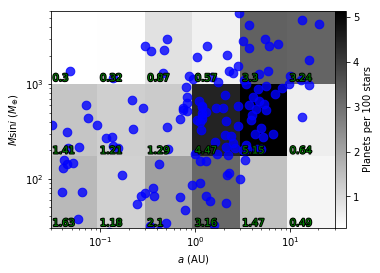

In [27]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.03, 30])
ax.set_ylim([30, 6000])
ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')

X = np.unique(np.exp(gridbins[:, 0]))
Y = np.unique(np.exp(gridbins[:, 1]))
C = modes.T#quartiles[:, :, 1].T

CS = ax.pcolormesh(X, Y, C, cmap=plt.cm.gray_r)
plt.colorbar(mappable=CS, pad=0, label='Planets per 100 stars')
ax.scatter(planets.axis, 317.8*planets.mass, c='blue', s=75, alpha=0.8) 
#'''
for n in np.arange(18):
    a = X[np.mod(n, 6)]
    m = Y[np.floor_divide(n, 6)]
    xy = np.array([a, m])
    
    if not zeros[np.mod(n, 6), np.floor_divide(n, 6)]:
        txt = np.round(modes[np.mod(n, 6), np.floor_divide(n, 6)], decimals=2)
    else:
        txt = '< ' + str(np.round(modes[np.mod(n, 6), np.floor_divide(n, 6)], decimals=2))

    text = ax.annotate(txt, xy=xy, xytext=1.05*xy, color='green')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                           path_effects.Normal()])
#'''   
fig.savefig('plots/checkerboard_6x3.pdf', bbox_inches='tight')

In [28]:
np.sum(modes)

32.789372126950084

In [29]:
np.sum(quartiles[:, :, 1]) # medians

40.83024506678356

In [34]:
np.save('planets_per_100_chains_6x3.npy', a_chains)
np.save('bins_6x3.npy', np.exp(gridbins))
np.save('planets_per_100_quartiles_6x3.npy', quartiles)

In [64]:
subjupbins = lngrid(0.03, 30., 30., 300, 11, 1) 
supjupbins = lngrid(0.03, 30., 300., 6000, 11, 1) 
hierarchical_sub = Hierarchy(samples_all, completey_all, bins=subjupbins[:-2], chainname='occur_chains_11x1_sub.csv')
hierarchical_sup = Hierarchy(samples_all, completey_all, bins=supjupbins, chainname='occur_chains_11x1_sup.csv')
hierarchical_sub.max_like()
hierarchical_sup.max_like()

In [65]:
hierarchical_sub.sample(parallel=True, gp=False)
hierarchical_sup.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [36:53<00:00,  2.21s/it]


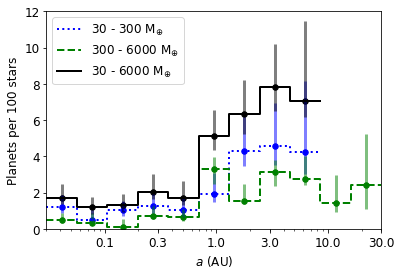

In [107]:
matplotlib.rcParams.update({'font.size': 12})
chains_sub = pd.read_csv('occur_chains_11x1_sub.csv')
chains_sup = pd.read_csv('occur_chains_11x1_sup.csv')

a_modes_sub = []
a_159_sub = []
a_841_sub = []
for n in np.arange(hierarchical_sub.nbins):
    chains = np.array([chains_sub['gamma{}'.format(n)]])*hierarchical_sub.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes_sub.append(bin_edges[np.argmax(hist)])
    a_159_sub.append(np.percentile(chains, 15.9))
    a_841_sub.append(np.percentile(chains, 84.1))
a_modes_sub = np.array(a_modes_sub)
a_159_sub = np.array(a_159_sub)
a_841_sub = np.array(a_841_sub)

a_modes_sup = []
a_159_sup = []
a_841_sup = []
for n in np.arange(hierarchical_sup.nbins):
    chains = np.array([chains_sup['gamma{}'.format(n)]])*hierarchical_sup.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes_sup.append(bin_edges[np.argmax(hist)])
    a_159_sup.append(np.percentile(chains, 15.9))
    a_841_sup.append(np.percentile(chains, 84.1))
a_modes_sup = np.array(a_modes_sup)
a_159_sup = np.array(a_159_sup)
a_841_sup = np.array(a_841_sup)

#[:len(chains_sub)]
a_modes_all = []
a_159_all = []
a_841_all = []
for n in np.arange(hierarchical_sub.nbins):
    chains = np.array([chains_sub['gamma{}'.format(n)]])*hierarchical_sub.bin_areas[0][0]*(100/719) + \
             np.array([chains_sup['gamma{}'.format(n)]])[:, :len(chains_sub)]*hierarchical_sup.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes_all.append(bin_edges[np.argmax(hist)])
    a_159_all.append(np.percentile(chains, 15.9))
    a_841_all.append(np.percentile(chains, 84.1))
a_modes_all = np.array(a_modes_all)
a_159_all = np.array(a_159_all)
a_841_all = np.array(a_841_all)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel('Planets per 100 stars')
ax.set_xlim([np.exp(hierarchical_sup.lna_edges[0]), np.exp(hierarchical_sup.lna_edges[-1])])
ax.set_ylim([0, 12])
lnaw_sub = subjupbins[0][0][1] - subjupbins[0][0][0]
lnaw_sup = supjupbins[0][0][1] - supjupbins[0][0][0]


ax.scatter(np.exp(hierarchical_sub.lna_edges[:-1] + 0.5*lnaw_sub), a_modes_sub,
           color='blue', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_sub.lna_edges[:-1] + 0.5*lnaw_sub), a_159_sub,
          a_841_sub, alpha=0.5, color='blue', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(hierarchical_sub.lna_edges[:-1] + lnaw_sub), 0, np.exp(hierarchical_sub.lna_edges[0])), 
        np.insert(a_modes_sub, 0, a_modes_sub[0]), color='blue', lw=2, linestyle=':', label=r'30 - 300 $\mathrm{M_{\oplus}}$')

ax.scatter(np.exp(hierarchical_sup.lna_edges[:-1] + 0.5*lnaw_sup), a_modes_sup,
           color='green', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_sup.lna_edges[:-1] + 0.5*lnaw_sup), a_159_sup,
          a_841_sup, alpha=0.5, color='green', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(hierarchical_sup.lna_edges[:-1] + lnaw_sup), 0, np.exp(hierarchical_sup.lna_edges[0])), 
        np.insert(a_modes_sup, 0, a_modes_sup[0]), color='green', lw=2, linestyle='--', label=r'300 - 6000 $\mathrm{M_{\oplus}}$')

ax.scatter(np.exp(hierarchical_sub.lna_edges[:-1] + 0.5*lnaw_sub), a_modes_all,
           color='black', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_sub.lna_edges[:-1] + 0.5*lnaw_sub), a_159_all,
          a_841_all, alpha=0.5, color='black', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(hierarchical_sub.lna_edges[:-1] + lnaw_sub), 0, np.exp(hierarchical_sub.lna_edges[0])), 
        np.insert(a_modes_all, 0, a_modes_all[0]), color='black', lw=2, label=r'30 - 6000 $\mathrm{M_{\oplus}}$')

ax.legend(loc=2) 

fig.savefig('plots/hist_super_sub_Jupiters_all.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/hist_super_sub_Jupiters_all.pdf', bbox_inches='tight')

In [95]:
subsatbins = lngrid(0.03, 30., 30., 150., 11, 1) 
hierarchical_sat = Hierarchy(samples_all, completey_all, bins=subsatbins[:-3], 
                             chainname='occur_chains_11x1_sat.csv')
hierarchical_sat.max_like()

In [96]:
hierarchical_sat.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [40:20<00:00,  2.42s/it]


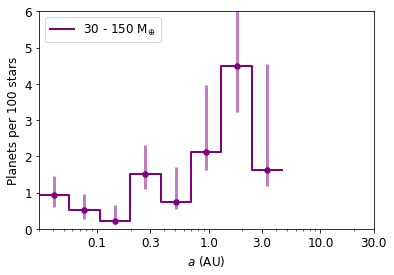

In [105]:
matplotlib.rcParams.update({'font.size': 12})
chains_sat = pd.read_csv('occur_chains_11x1_sat.csv')

a_modes_sat = []
a_159_sat = []
a_841_sat = []
for n in np.arange(hierarchical_sat.nbins):
    chains = np.array([chains_sat['gamma{}'.format(n)]])*hierarchical_sat.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes_sat.append(bin_edges[np.argmax(hist)])
    a_159_sat.append(np.percentile(chains, 15.9))
    a_841_sat.append(np.percentile(chains, 84.1))
a_modes_sat = np.array(a_modes_sat)
a_159_sat = np.array(a_159_sat)
a_841_sat = np.array(a_841_sat)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel('Planets per 100 stars')
ax.set_xlim([np.exp(hierarchical_sup.lna_edges[0]), np.exp(hierarchical_sup.lna_edges[-1])])
ax.set_ylim([0, 6])
lnaw_sat = subsatbins[0][0][1] - subsatbins[0][0][0]

ax.scatter(np.exp(hierarchical_sub.lna_edges[:-2] + 0.5*lnaw_sat), a_modes_sat,
           color='purple', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_sub.lna_edges[:-2] + 0.5*lnaw_sat), a_159_sat,
          a_841_sat, alpha=0.5, color='purple', lw=3, label='_nolegend_')
ax.step(np.insert(np.exp(hierarchical_sub.lna_edges[:-2] + lnaw_sat), 0, np.exp(hierarchical_sat.lna_edges[0])), 
        np.insert(a_modes_sat, 0, a_modes_sat[0]), color='purple', lw=2, label=r'30 - 150 $\mathrm{M_{\oplus}}$')

ax.legend(loc=2) 

fig.savefig('plots/hist_subSats.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/hist_subSats.pdf', bbox_inches='tight')

## Compute and visualize observed small planet multiplicity.

In [55]:
names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)
multistats = []
singlenames = []
multinames = []
smallnames = []

bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215']

for name in names:
    sample = planets.query('mass < 0.1 and hostname == @name')
    nsmalls = len(sample)
    if nsmalls >= 1:
        smallnames.append(name)
    multistats.append(nsmalls)
    
    if nsmalls == 1:
        singlenames.append(name)
    elif nsmalls > 1:
        multinames.append(name)
    else:
        pass

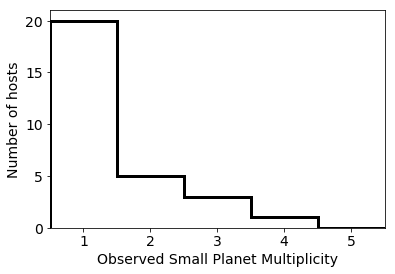

In [56]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.hist(multistats, color='black', histtype='step', lw=3, range=(0.5, 5.5), bins=5)
ax.set_xlim([0.5, 5.5])
ax.set_xlabel('Observed Small Planet Multiplicity')
ax.set_ylabel('Number of hosts')
fig.savefig('plots/observed_small_multiplicity.pdf', bbox_inches='tight')

In [30]:
singles = multistats.count(1)
starmultis = multistats.count(2) + multistats.count(3) + multistats.count(4) + multistats.count(5)
planetmultis = 2*multistats.count(2) + 3*multistats.count(3) + 4*multistats.count(4) + 5*multistats.count(5)

print(singles, starmultis, planetmultis)

19 9 23


### Make lists of outer giant hosts without inner small planets, and small planet hosts without outer giants, for clean contour plots.

In [58]:
print(len(supernames), len(allouternames))

28 81


In [28]:
superclean = [x for x in supernames if x not in allouternames]
outerclean = [x for x in allouternames if x not in supernames]

In [60]:
print(len(superclean), len(outerclean))

20 73


In [61]:
with open('names_superclean.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in superclean:
        writer.writerow([name])

with open('names_outerclean.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in outerclean:
        writer.writerow([name])

In [21]:
recoveries_superclean = pd.read_csv('../recovery_files/recoveries_superclean_earth.csv')
completey_superclean  = Completeness(recoveries_superclean)
completey_superclean.completeness_grid([0.01, 40], [2, 9000])

recoveries_outerclean = pd.read_csv('../recovery_files/recoveries_outerclean_earth.csv')
completey_outerclean  = Completeness(recoveries_outerclean)
completey_outerclean.completeness_grid([0.01, 40], [2, 9000])

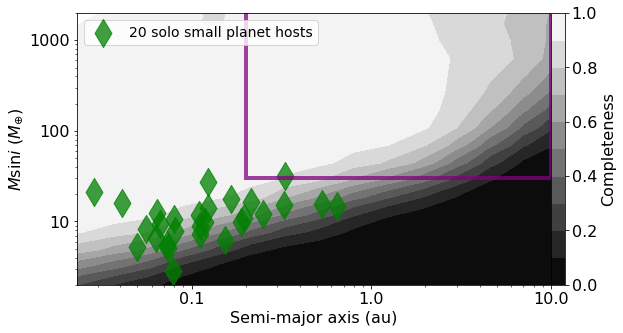

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_superclean.grid[0], completey_superclean.grid[1],
                 completey_superclean.grid[2], 10, cmap=plt.cm.gray)

solos_in   = solos.query('axis < 1')
lonelysolos = np.unique(solos_in.hostname)

matplotlib.rcParams.update({'font.size': 16})
ax.scatter(solos_in.axis, 317.8*solos_in.mass, c='g', s=400, alpha=0.75, 
           label='{} solo small planet hosts'.format(len(lonelysolos)), marker='d')
ax.set_xlim([2.3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=2, fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

xout = [0.2, 10]
yout = [30, 6000]
ax.add_patch(Rectangle((xout[0], yout[0]), xout[1]-xout[0], yout[1]-yout[0], 
             lw=4, color='purple', fill=False, alpha=0.75))

fig.savefig('plots/superclean_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/superclean_planet_contours.pdf', bbox_inches='tight')

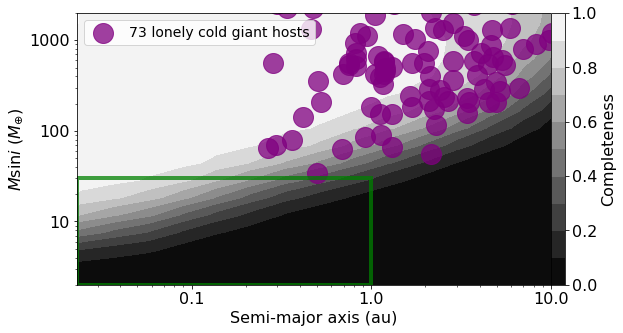

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_outerclean.grid[0], completey_outerclean.grid[1],
                 completey_outerclean.grid[2], 10, cmap=plt.cm.gray)

outerclean_sample = all_outers.query('axis > 0.23 and hostname in @outerclean')
lonelygiants = np.unique(outerclean_sample.hostname)

matplotlib.rcParams.update({'font.size': 16})
ax.scatter(outerclean_sample.axis, 317.8*outerclean_sample.mass, c='purple', s=400, alpha=0.75, 
           label='{} lonely cold giant hosts'.format(len(lonelygiants)))
ax.set_xlim([2.3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=2, fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

xin = [0.023, 1]
yin = [2, 30]
ax.add_patch(Rectangle((xin[0], yin[0]), xin[1]-xin[0], yin[1]-yin[0], 
             lw=4, color='green', fill=False, alpha=0.75))

fig.savefig('plots/outerclean_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/outerclean_planet_contours.pdf', bbox_inches='tight')

### Stack contours for warm giants and place limits on small planet nondetection.

In [26]:
warmnames = np.unique(planets.query('axis>=0.23 and axis<2.84 and mass>=122/317.8 and mass<2000/317.8').hostname)

In [34]:
len(warmnames)

38

In [35]:
with open('names_warmgiants.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in warmnames:
        writer.writerow([name])

## Save table of probabilities and write to LaTeX table.

In [129]:
chains = hierarchical_small_fraction.chains*hierarchical_small_fraction.bin_areas[0][0]/719
I        = np.round(np.percentile(chains, 50), 4)
I_minus  = np.round(np.percentile(chains, 15.9), 4)
I_plus   = np.round(np.percentile(chains, 84.1), 4)

chains = hierarchical_outer_fraction_all.chains*hierarchical_outer_fraction_all.bin_areas[0][0]/719
O        = np.round(np.percentile(chains, 50), 4)
O_minus  = np.round(np.percentile(chains, 15.9), 4)
O_plus   = np.round(np.percentile(chains, 84.1), 4)

chains = hierarchical_outer_fraction.chains*hierarchical_outer_fraction.bin_areas[0][0]/nsuperstars
OI        = np.round(np.percentile(chains, 50), 4)
OI_minus  = np.round(np.percentile(chains, 15.9), 4)
OI_plus   = np.round(np.percentile(chains, 84.1), 4)

chains = hierarchical_inner.chains*hierarchical_inner.bin_areas[0][0]/nouterstars
IO        = np.round(np.percentile(chains, 50), 4)
IO_minus  = np.round(np.percentile(chains, 15.9), 4)
IO_plus   = np.round(np.percentile(chains, 84.1), 4)

#I  = ABOVE, SAME

chains = hierarchical_outer_fraction_jupi.chains*hierarchical_outer_fraction_jupi.bin_areas[0][0]/719
J        = np.round(np.percentile(chains, 50), 4)
J_minus  = np.round(np.percentile(chains, 15.9), 4)
J_plus   = np.round(np.percentile(chains, 84.1), 4)

chains = hierarchical_outer_marta.chains*hierarchical_outer_marta.bin_areas[0][0]/nsuperstars
JI        = np.round(np.percentile(chains, 50), 4)
JI_minus  = np.round(np.percentile(chains, 15.9), 4)
JI_plus   = np.round(np.percentile(chains, 84.1), 4)

chains = hierarchical_inner_marta.chains*hierarchical_inner_marta.bin_areas[0][0]/nouterstars_marta
IJ        = np.round(np.percentile(chains, 50), 4)
IJ_minus  = np.round(np.percentile(chains, 15.9), 4)
IJ_plus   = np.round(np.percentile(chains, 84.1), 4)

In [130]:
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(I, I_plus - I, I - I_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(O, O_plus - O, O - O_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(J, J_plus - J, J - J_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(OI, OI_plus - OI, OI - OI_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(JI, JI_plus - JI, JI - JI_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(IO, IO_plus - IO, IO - IO_minus) + r'$')
print(r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(IJ, IJ_plus - IJ, IJ - IJ_minus) + r'$')

$0.2758^{+0.05830000000000002}_{-0.04819999999999999}$
$0.1758^{+0.0242}_{-0.018600000000000005}$
$0.0719^{+0.013600000000000001}_{-0.012500000000000004}$
$0.4057^{+0.14999999999999997}_{-0.12719999999999998}$
$0.1327^{+0.09689999999999999}_{-0.0632}$
$0.4172^{+0.17189999999999994}_{-0.1326}$
$0.3205^{+0.2409}_{-0.15990000000000001}$


In [ ]:
massin = r'$' + '{0}^{{+{1}}}_{{-{2}}}'.format(mass_str, mass_plus_str, mass_minus_str) + r'$'    

In [ ]:
tex_writer = open('tables/tex_tables/super_table.tex', 'w')
tex_writer.write(r'\begin{longtable*}{llrrrrr}')
tex_writer.write('\n')
tex_writer.write(r'\caption{Small Planet Sample}' + r' \\')


tex_writer.write(r'\bottomrule' + ' \n')
tex_writer.write(r'\end{longtable*}' + ' \n')
tex_writer.close()

### Generate list of names for more specific subset of small planets, for contour generation. 0.023--0.5 au, 3--10 Earth masses.

In [12]:
supers

Unnamed: 0  hostname status  pl_index      mass  mass_med  mass_minus  \
0            6    107148      C       2.0  0.067845  0.062633    0.052797   
1           16    115617      K       1.0  0.051309  0.050675    0.047007   
2           17    115617      K       2.0  0.016240  0.016078    0.014473   
3           22    11964a      K       2.0  0.077996  0.076625    0.070477   
4           35      1326      K       1.0  0.017233  0.017080    0.015764   
5           45    141004      C       1.0  0.043896  0.042869    0.038311   
6           61      1461      K       1.0  0.020805  0.020755    0.019000   
7           62      1461      K       2.0  0.022990  0.022244    0.019398   
8           67   147379a      K       1.0  0.099075  0.096502    0.084656   
9           73    156668      K       2.0  0.016054  0.015830    0.014511   
10          81    164922      K       2.0  0.045698  0.045111    0.041567   
11          82    164922      C       3.0  0.034078  0.033118    0.030034   
12          83    164922      K       4.0  0.015214  0.014873    0.012801   
13          88    168009      C       2.0  0.030927  0.030019    0.026336   
14         113    190360      K       2.0  0.067746  0.067457    0.064805   
15         119    192310      K       1.0  0.047486  0.045053    0.039119   
16         140    216520      K       2.0  0.034196  0.032642    0.028838   
17         150    219134      K       2.0  0.052166  0.051641    0.048652   
18         151    219134      K       3.0  0.013096  0.012974    0.011896   
19         153    219134      K       5.0  0.024599  0.024312    0.022145   
20         154    219134      K       6.0  0.011640  0.011239    0.009821   
21         172    285968      K       1.0  0.029413  0.028523    0.024196   
22         203     45184      K       1.0  0.038645  0.037467    0.033695   
23         204     45184      K       2.0  0.037389  0.034447    0.028641   
24         229     69830      K       1.0  0.033201  0.032282    0.030263   
25         230     69830      K       2.0  0.031005  0.031016    0.028069   
26         241     75732      K       5.0  0.029567  0.029471    0.028115   
27         244      7924      K       1.0  0.025985  0.025899    0.024514   
28         245      7924      K       2.0  0.028026  0.027800    0.025937   
29         247      7924      K       4.0  0.019577  0.019184    0.017139   
30         260     90156      K       1.0  0.038204  0.037063    0.031057   
31         270     95735      K       2.0  0.008983  0.008821    0.007838   
32         275     97101      K       4.0  0.033790  0.032220    0.028371   
33         277     97658      K       1.0  0.024927  0.024686    0.022942   
34         286     99492      K       1.0  0.085014  0.084127    0.078003   
35         293     gl687      K       1.0  0.056073  0.055301    0.050632   
36         303  hip74995      K       1.0  0.050934  0.051054    0.049142   
37         304  hip74995      K       2.0  0.015964  0.015926    0.013743   
38         307  hip57087      K       1.0  0.066870  0.066757    0.064590   
39         327     gl876      K       4.0  0.018960  0.018427    0.016899   

    mass_plus      axis  axis_med  ...      e_68        insol    insol_med  \
0    0.072335  0.140652  0.140650  ...  0.401911    67.907955    67.927727   
1    0.054186  0.215031  0.215051  ...  0.099262    20.134729    20.127750   
2    0.017753  0.049558  0.049563  ...  0.141640   379.065701   378.949258   
3    0.082858  0.231507  0.231511  ...  0.146884    57.305599    57.252597   
4    0.018399  0.073202  0.073202  ...  0.108167     4.629984     4.630508   
5    0.047486  0.123777  0.123790  ...  0.215525   135.627013   135.632917   
6    0.022689  0.063605  0.063603  ...  0.088530   309.796966   310.011339   
7    0.025017  0.112105  0.112098  ...  0.156323    99.726198    99.806430   
8    0.108280  0.331469  0.331488  ...  0.143678     0.934296     0.933760   
9    0.017163  0.050246  0.050244  ...  0.268908   123.266347   12

In [13]:
minisupers = supers.query('axis >= 0.023 and axis < 0.5 and mass >= 3/317.8 and mass < 10/317.8')

In [14]:
minisupers

Unnamed: 0  hostname status  pl_index      mass  mass_med  mass_minus  \
2           17    115617      K       2.0  0.016240  0.016078    0.014473   
4           35      1326      K       1.0  0.017233  0.017080    0.015764   
6           61      1461      K       1.0  0.020805  0.020755    0.019000   
7           62      1461      K       2.0  0.022990  0.022244    0.019398   
9           73    156668      K       2.0  0.016054  0.015830    0.014511   
12          83    164922      K       4.0  0.015214  0.014873    0.012801   
13          88    168009      C       2.0  0.030927  0.030019    0.026336   
18         151    219134      K       3.0  0.013096  0.012974    0.011896   
19         153    219134      K       5.0  0.024599  0.024312    0.022145   
20         154    219134      K       6.0  0.011640  0.011239    0.009821   
21         172    285968      K       1.0  0.029413  0.028523    0.024196   
25         230     69830      K       2.0  0.031005  0.031016    0.028069   
27         244      7924      K       1.0  0.025985  0.025899    0.024514   
28         245      7924      K       2.0  0.028026  0.027800    0.025937   
29         247      7924      K       4.0  0.019577  0.019184    0.017139   
33         277     97658      K       1.0  0.024927  0.024686    0.022942   
37         304  hip74995      K       2.0  0.015964  0.015926    0.013743   

    mass_plus      axis  axis_med  ...      e_68       insol   insol_med  \
2    0.017753  0.049558  0.049563  ...  0.141640  379.065701  378.949258   
4    0.018399  0.073202  0.073202  ...  0.108167    4.629984    4.630508   
6    0.022689  0.063605  0.063603  ...  0.088530  309.796966  310.011339   
7    0.025017  0.112105  0.112098  ...  0.156323   99.726198   99.806430   
9    0.017163  0.050246  0.050244  ...  0.268908  123.266347  123.303176   
12   0.016943  0.102336  0.102336  ...  0.255071   72.755889   72.750376   
13   0.033793  0.119264  0.119246  ...  0.172219  102.871384  102.957010   
18   0.014000  0.038381  0.038375  ...  0.094572  188.168808  188.156135   
19   0.026595  0.145348  0.145328  ...  0.107707   13.120617   13.120245   
20   0.012608  0.064667  0.064657  ...  0.218302   66.284692   66.284545   
21   0.032843  0.066491  0.066490  ...  0.226120    8.730870    8.727840   
25   0.034075  0.188218  0.188186  ...  0.159024   17.200783   17.212234   
27   0.027321  0.055952  0.055951  ...  0.068521  124.628143  124.537696   
28   0.029769  0.112066  0.112064  ...  0.131598   31.066732   31.045207   
29   0.021313  0.153171  0.153156  ...  0.218944   16.629819   16.620521   
33   0.026468  0.080460  0.080461  ...  0.090492   57.382075   57.399059   
37   0.018100  0.073584  0.073586  ...  0.173256    2.444216    2.444956   

    insols_minus  insols_plus       teq   teq_med   teq_minus    teq_plus  \
2     350.629305   409.144916  0.146582  0.146593  350.629305  409.144916   
4       4.402979     4.866417  0.440925  0.440912    4.402979    4.866417   
6     283.998027   337.741704  0.154167  0.154140  283.998027  337.741704   
7      91.428833   108.720831  0.204671  0.204630   91.428833  108.720831   
9     115.918078   131.067907  0.194110  0.194096  115.918078  131.067907   
12     67.703534    78.033729  0.221459  0.221463   67.703534   78.033729   
13     94.396928   111.920676  0.203089  0.203047   94.396928  111.920676   
18    176.059148   200.770532  0.174632  0.174634  176.059148  200.770532   
19     12.276311    13.998899  0.339837  0.339840   12.276311   13.998899   
20     62.020037    70.728049  0.226676  0.226676   62.020037   70.728049   
21      8.308459     9.168796  0.376266  0.376299    8.308459    9.168796   
25     15.884968    18.647442  0.317594  0.317541   15.884968   18.647442   
27    115.721289   134.077054  0.193578  0.193613  115.721289  134.077054   
28     28.846005    33.423934  0.273959  0.274007   28.846005   33.423934   
29     15.444377    17.894043  0.320286  0.320331   15.444377   17.894043   
33     53.596588

In [15]:
mininames = np.unique(minisupers.hostname)

In [17]:
with open('names_minisuper.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in mininames:
        writer.writerow([name])

In [15]:
lauren_giants = planets.query('axis >= 1 and axis < 5 and mass >= 1 and mass < 20')

In [16]:
lauren_names  = np.unique(lauren_giants.hostname)

In [9]:
with open('names_lauren.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in lauren_names:
        writer.writerow([name])

In [25]:
lukewarm_names = np.unique(planets.query('mass>=0.1 and axis>=0.23 and axis<3').hostname)

with open('names_lukewarm.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in lukewarm_names:
        writer.writerow([name])
        
cold_names = np.unique(planets.query('mass>=0.1 and axis>=3').hostname)

with open('names_cold.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for name in cold_names:
        writer.writerow([name])

In [19]:
lauren_giants

Unnamed: 0   hostname status  pl_index       mass   mass_med  mass_minus  \
1             4      10697      K       1.0   6.394219   6.392002    6.258561   
4             8     108874      K       1.0   1.322192   1.319663    1.272192   
5             9     108874      K       2.0   1.143530   1.139486    1.089972   
7            14     114783      K       1.0   1.034819   1.032731    0.999197   
12           20     117207      K       1.0   1.872094   1.869543    1.795250   
18           29      12661      K       2.0   1.859748   1.855497    1.801049   
20           32     128311      K       1.0   3.284585   3.250563    3.130206   
21           33     128311      K       2.0   2.089700   2.004485    1.849179   
30           47     141399      K       2.0   1.270786   1.263133    1.216009   
35           57     145675      K       1.0   4.847843   4.850670    4.705176   
37           60     145934      K       1.0   2.069045   2.039347    1.809421   
51           84     167042      K       1.0   1.603279   1.593906    1.468344   
54           90     168443      K       2.0  17.756055  17.758193   17.408982   
57           93     169830      K       2.0   3.516503   3.511370    3.394927   
59           96     177830      K       1.0   1.342935   1.347580    1.248638   
64          106     186427      K       1.0   1.753052   1.752382    1.698974   
66          108     187123      K       2.0   1.714340   1.712769    1.655453   
67          109     188015      K       1.0   1.454574   1.454088    1.394289   
69          112     190360      K       1.0   1.491530   1.492034    1.449298   
75          132     210277      K       1.0   1.236319   1.236339    1.204224   
88          159     222582      K       1.0   7.898404   7.878265    7.640243   
89          162      24040      K       1.0   4.064210   4.051328    3.906306   
92          170      28185      K       1.0   6.032913   6.037505    5.836369   
96          180      33636      K       1.0   8.924907   8.927846    8.631030   
100         190      38529      K       1.0  13.218543  13.214594   13.112682   
103         194       4203      K       1.0   1.807259   1.822013    1.744259   
109         206      45350      K       1.0   1.774647   1.821184    1.750599   
112         213      50499      K       1.0   1.304681   1.346304    1.259686   
114         215      50554      K       1.0   4.351335   4.348375    4.166707   
116         222      66428      K       1.0   3.179829   3.191999    3.083945   
123         233      72659      K       1.0   2.822173   2.849142    2.733440   
124         235      74156      K       1.0   7.648036   7.648576    7.379604   
136         251      82943      K       2.0   1.541387   1.538629    1.486184   
138         259      87883      K       1.0   2.296141   2.291653    2.222793   
142         265      95128      K       1.0   2.405106   2.438191    2.353237   
152         281       9826      K       3.0   4.102343   4.095712    3.993074   
155         289      gl317      K       1.0   1.853827   1.852605    1.815638   
159         296  hip109388      K       2.0   1.085623   1.078622    1.025574   
173         322     183263      K       1.0   3.704948   3.704389    3.605320   

     mass_plus      axis  axis_med  ...      e_68     insol  insol_med  \
1     6.525625  2.156211  2.155973  ...  0.103728  0.680245   0.680075   
4     1.367061  1.052723  1.052494  ...  0.152098  0.927674   0.928651   
5     1.191026  2.830895  2.829654  ...  0.279496  0.128285   0.128468   
7     1.066385  1.163828  1.163881  ...  0.134039  0.323354   0.323434   
12    1.946500  3.743901  3.744161  ...  0.154149  0.082141   0.082129   
18    1.909187  2.860844  2.860550  ...  0.030811  0.161647   0.161504   
20    3.373816  1.741201  1.741508  ...  0.218412  0.107432   0.107418   
21    2.160316  1.088539  1.088308  ...  0.302133  0.274880   0.275067   
30    1.310296  2.115371  2.113947  ...  0.050163  0.378046   0.378641   
35    4.996723  2.830292

In [20]:
laurenbins = lngrid(1., 5., 317.8, 20*317.8, 1, 1) 
hierarchical_outer_lauren = Hierarchy(samples_all, completey_all, 
                                             chainname='occur_chains/occur_chains_lauren.csv',
                                             fraction=True, nstars=719,
                                             bins=laurenbins)
hierarchical_outer_lauren.max_like()

In [21]:
hierarchical_outer_lauren.sample()

100%|██████████| 1000/1000 [03:15<00:00,  5.13it/s]


In [22]:
print(np.median(hierarchical_outer_lauren.chains)*hierarchical_outer_lauren.bin_areas[0][0]/719,
  '+/-', np.std(hierarchical_outer_lauren.chains)*hierarchical_outer_lauren.bin_areas[0][0]/719)

0.07086070440322162 +/- 0.010994960893279603


## Plot Marta's outer companion sample.

In [21]:
masses = [9.84, 4.46, 0.84, 2.07, 3.88, 0.68, 0.65, 0.54, 4.96, 1.29]
axes   = [1.6, 1.29, 1.47, 1.85, 5.5, 3.56, 1.76, 3., 1.82, 1.38]

Text(0, 0.5, '$M$ (M$_{\\mathrm{J}}$)')

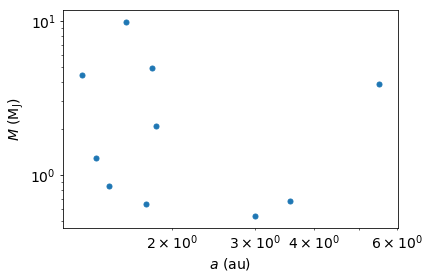

In [25]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(axes, masses)
ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$M$ (M$_{\mathrm{J}}$)')

## Test Gaussian mass distribution. Make one up to start, papers don't give straightforward answers.

(0.01, 30)

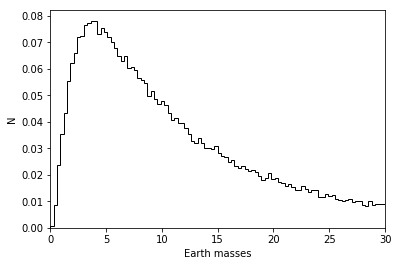

In [80]:
gsamples = np.random.normal(loc=np.log(10), scale=1, size=10**5)
fig, ax = plt.subplots()
ax.hist(np.exp(gsamples), histtype='step', color='black', 
        range=(0.01, 30), bins=100, density=True)
ax.set_xlabel('Earth masses')
ax.set_ylabel('N')
ax.set_xlim([0.01, 30])
#ax.set_xscale('log', basex=np.e)

(0, 0.16)

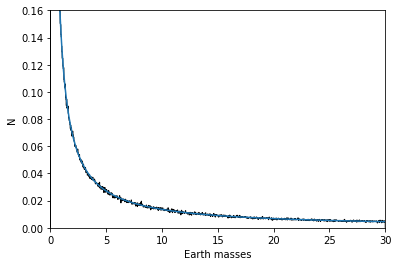

In [108]:
lnsamples = np.random.uniform(-4, np.log(30), size=10**6)
x = np.linspace(0.00001, 30, 1000)

fig, ax = plt.subplots()
ax.hist(np.exp(lnsamples), histtype='step', color='black', 
        range=(0, 30), bins=1000, density=True)
ax.plot(x, 1/(x*np.e**2))
ax.set_xlabel('Earth masses')
ax.set_ylabel('N')
ax.set_xlim([0, 30])
ax.set_ylim([0, 0.16])
#ax.set_xscale('log', basex=np.e)

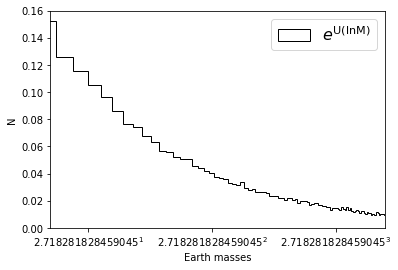

In [71]:
lnsamples = np.random.uniform(0, np.log(30), size=10**5)

fig, ax = plt.subplots()
ax.hist(np.exp(lnsamples), histtype='step', color='black', 
        range=(0, 30), bins=100, density=True, label=r'$e^\mathrm{U(lnM)}$')
ax.set_xlabel('Earth masses')
ax.set_ylabel('N')
ax.set_xlim([2, 30])
ax.set_ylim([0, 0.16])
ax.legend(fontsize=16)
ax.set_xscale('log', basex=np.e)

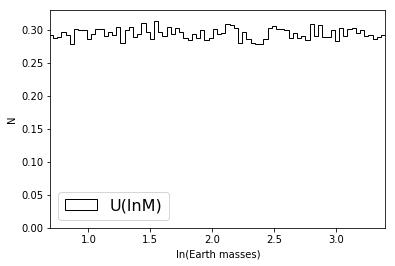

In [69]:
lnsamples = np.random.uniform(0, np.log(30), size=10**5)

fig, ax = plt.subplots()
ax.hist(lnsamples, histtype='step', color='black', 
        range=(0, np.log(30)), bins=100, density=True, label='U(lnM)')
ax.set_xlabel('ln(Earth masses)')
ax.set_ylabel('N')
ax.set_xlim([np.log(2), np.log(30)])
ax.legend(fontsize=16, loc=3)
#ax.set_ylim([0, 0.16])
#ax.set_xscale('log', basex=np.e)

In [21]:
recoveries_outer = pd.read_csv('../recovery_files/recoveries_outer_earth.csv')
completey_outer  = Completeness(recoveries_outer)
completey_outer.completeness_grid([0.01, 40], [2, 9000])

In [94]:
# 8 Earth masses, scale of 1.
yessies = []
n = 10**5
gsamples = np.random.normal(loc=np.log(8), scale=1, size=n)
for i in range(n):
    completeybla = completey_outer.interpolate(np.exp(np.random.uniform(np.log(0.023), 0)), 
                                               np.exp(np.random.choice(gsamples)))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.27663 0.5961866270852565


In [21]:
# Neil & Rogers 2020, mu_M = 0.29, sigma_M = 1.72
yessies = []
n = 10**5
gsamples = np.random.normal(loc=0.29, scale=1.72, size=n)
for i in range(n):
    completeybla = completey_outer.interpolate(np.exp(np.random.uniform(np.log(0.023), 0)), 
                                               np.exp(np.random.choice(gsamples)))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.09377 0.5847819192123781


In [21]:
# Neil & Rogers 2020, mu_M = 0.6, sigma_M = 2.39
yessies = []
n = 10**5
gsamples = np.random.normal(loc=0.6, scale=2.39, size=n)
for i in range(n):
    completeybla = completey_outer.interpolate(np.exp(np.random.uniform(np.log(0.023), 0)), 
                                               np.exp(np.random.choice(gsamples)))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.18329 0.7252252859323542


In [11]:
yessies = []
n = 10**5
for i in range(n):
    completeybla = completey_outer.interpolate(np.exp(np.random.uniform(np.log(0.023), 0)), 
                                               np.exp(np.random.uniform(np.log(2), np.log(30))))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.25065 0.5418330503946128


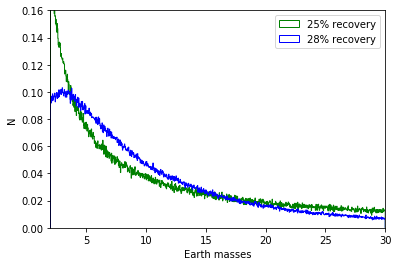

In [29]:
lnsamples = np.random.uniform(-4, np.log(30), size=10**6)
gsamples = np.random.normal(loc=np.log(8), scale=1, size=10**6)
nrsamples = np.random.normal(loc=0.29, scale=1.72, size=10**6)

fig, ax = plt.subplots()
ax.hist(np.exp(lnsamples), histtype='step', color='green', 
        range=(2, 30), bins=1000, density=True, label='25% recovery')
ax.hist(np.exp(gsamples), histtype='step', color='blue', 
        range=(2, 30), bins=1000, density=True, label='28% recovery')
#ax.hist(np.exp(nrsamples), histtype='step', color='brown', 
#        range=(2, 30), bins=1000, density=True, label='9.3% recovery')
ax.set_xlabel('Earth masses')
ax.set_ylabel('N')
ax.set_xlim([2, 30])
ax.set_ylim([0, 0.16])
ax.legend()
#ax.set_xscale('log', basex=np.e)

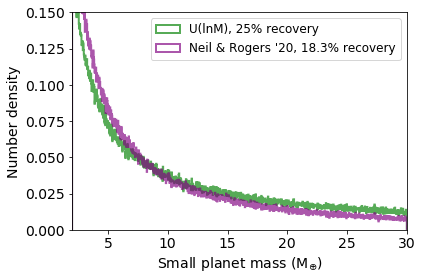

In [37]:
matplotlib.rcParams.update({'font.size': 14})

lnsamples = np.random.uniform(-4, np.log(30), size=10**6)
gsamples = np.random.normal(loc=0.6, scale=2.38, size=10**6)
#nrsamples = np.random.normal(loc=0.29, scale=1.72, size=10**6)

fig, ax = plt.subplots()
ax.hist(np.exp(lnsamples), histtype='step', color='green', alpha=0.66, lw=2,
        range=(2, 30), bins=1000, density=True, label='U(lnM), 25% recovery')
ax.hist(np.exp(gsamples), histtype='step', color='purple', alpha=0.66, lw=2,
        range=(2, 30), bins=1000, density=True, label='Neil & Rogers \'20, 18.3% recovery')
#ax.hist(np.exp(nrsamples), histtype='step', color='brown', 
#        range=(2, 30), bins=1000, density=True, label='9.3% recovery')
ax.set_xlabel(r'Small planet mass (M$_{\oplus}$)')
ax.set_ylabel('Number density')
ax.set_xlim([2, 30])
ax.set_ylim([0, 0.15])
ax.legend(fontsize=12)

fig.savefig('plots/small_mass_distributions.pdf', bbox_inches='tight')

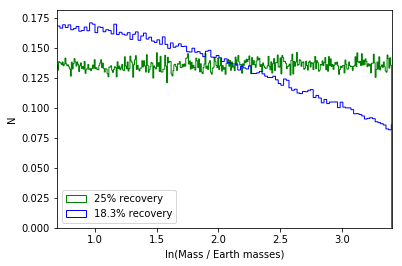

In [32]:
lnsamples = np.random.uniform(-4, np.log(30), size=10**6)
gsamples = np.random.normal(loc=0.6, scale=2.38, size=10**6)
#nrsamples = np.random.normal(loc=0.29, scale=1.72, size=10**6)

fig, ax = plt.subplots()
ax.hist(lnsamples, histtype='step', color='green', #range=(2, 30), 
        bins=1000, density=True, label='25% recovery')
ax.hist(gsamples, histtype='step', color='blue', 
        bins=1000, density=True, label='18.3% recovery')
#ax.hist(np.exp(nrsamples), histtype='step', color='brown', 
#        range=(2, 30), bins=1000, density=True, label='9.3% recovery')
ax.set_xlabel('ln(Mass / Earth masses)')
ax.set_ylabel('N')
#ax.set_yscale('log')
ax.set_xlim([np.log(2), np.log(30)])
#ax.set_ylim([0, 0.16])
ax.legend(loc=3)
#ax.set_xscale('log', basex=np.e)

In [14]:
yessies = []
n = 10**5
for i in range(n):
    completeybla = completey_outer.interpolate(np.random.uniform(0.023, 1), 
                                               np.exp(np.random.uniform(np.log(2), np.log(30))))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.12775 0.383009187953726


In [21]:
yessies = []
n = 10**5
for i in range(n):
    completeybla = completey_outer.interpolate(np.random.uniform(0.023, 1), 
                                               np.random.uniform(2, 30))
    if completeybla > np.random.uniform():
        yessies.append(completeybla)
    
print(len(yessies)/n, np.mean(yessies))

0.2274 0.42656554293829246


In [71]:
yessies = []
n = 10**5
for i in range(n):
    if 0.8 > np.random.uniform():
        yessies.append(0.8)
    
print(len(yessies)/n)

0.80172
